### <b>Tumor_Tissue_Image_Metadata_Explorer</b>

---




In [ ]:
# -*- coding: utf-8 -*-
"""Tumor_Tissue_Image_Metadata_Explorer.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1hgkt-6B2Wdg61gImesffQWhi9ntTLgMI

### Tumor_Tissue_Image_Metadata_Explorer

numpy, pandas → data handling
matplotlib, seaborn → plots (histograms, heatmaps, ROC curves)
scikit-learn → preprocessing, ML models, metrics, PCA
xgboost → powerful gradient boosting classifier
shap → feature importance & explainability
"""

# Core libraries
import numpy as np
import pandas as pd
import math
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & ML
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, roc_auc_score, classification_report, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE # alternate for PCA
from sklearn.pipeline import Pipeline

# Dimensionality reduction
from sklearn.decomposition import PCA

# Gradient boosting
import xgboost as xgb
from xgboost import XGBClassifier

# Dataset download
import kagglehub

# Explainability
!pip install shap -q
import shap

# Document generation
!pip install python-docx -q
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
import glob # The glob library is typically used for finding files using wildcard patterns (like *.csv or *.png)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 5.3 MB/s eta 0:00:00


Imprting datatset from "https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data"  

dated 8 Sept 2025

License: CC BY-NC-SA 4.0

In [ ]:
# Download the dataset
path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'breast-cancer-wisconsin-data' dataset.
Path to dataset files: /kaggle/input/breast-cancer-wisconsin-data


In [ ]:
os.makedirs("results/tables", exist_ok=True)
os.makedirs("results/plots", exist_ok=True)

In [ ]:
print(os.listdir(path))

['data.csv']


In [ ]:
df = pd.read_csv(os.path.join(path, "data.csv"))
df.head()
# Save first few rows (head) for report
head_table_path = "results/tables/data_head_SampleData.csv"
df.head().to_csv(head_table_path, index=False)

print(f"✅ Data head saved: {head_table_path}")

✅ Data head saved: results/tables/data_head_SampleData.csv


In [ ]:
df.shape

(569, 33)

Drop useless columns:

id (identifier, not a feature)

Unnamed: 32 (empty column)

In [ ]:
df = df.drop(['id', 'Unnamed: 32'], axis=1)

In [ ]:
df.shape

(569, 31)

In [ ]:
df['diagnosis'].value_counts()
# Save class distribution (diagnosis counts)
class_dist_path = "results/tables/class_distribution.csv"
df["diagnosis"].value_counts().to_csv(class_dist_path)

print(f"✅ Class distribution saved: {class_dist_path}")

✅ Class distribution saved: results/tables/class_distribution.csv


**Exploratory Data Analysis**


**Class distribution**

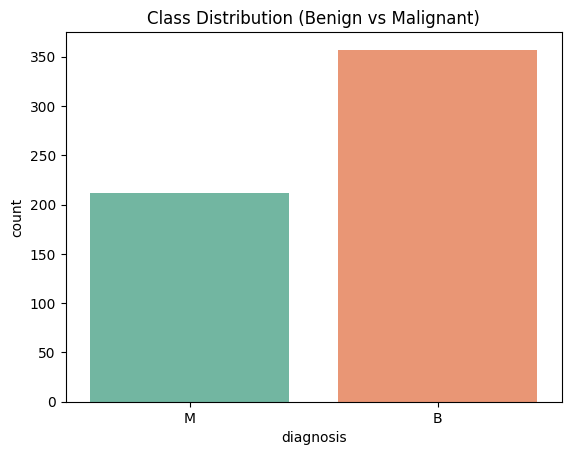

In [ ]:
# Create the plots directory if it doesn't exist
os.makedirs("results/plots", exist_ok=True)

# Plot
sns.countplot(data=df, x="diagnosis", hue="diagnosis", palette="Set2", legend=False)
plt.title("Class Distribution (Benign vs Malignant)")

# Save plot as PNG to 'plots' folder
plt.savefig("results/plots/class_distribution.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

**Feature histograms by class**

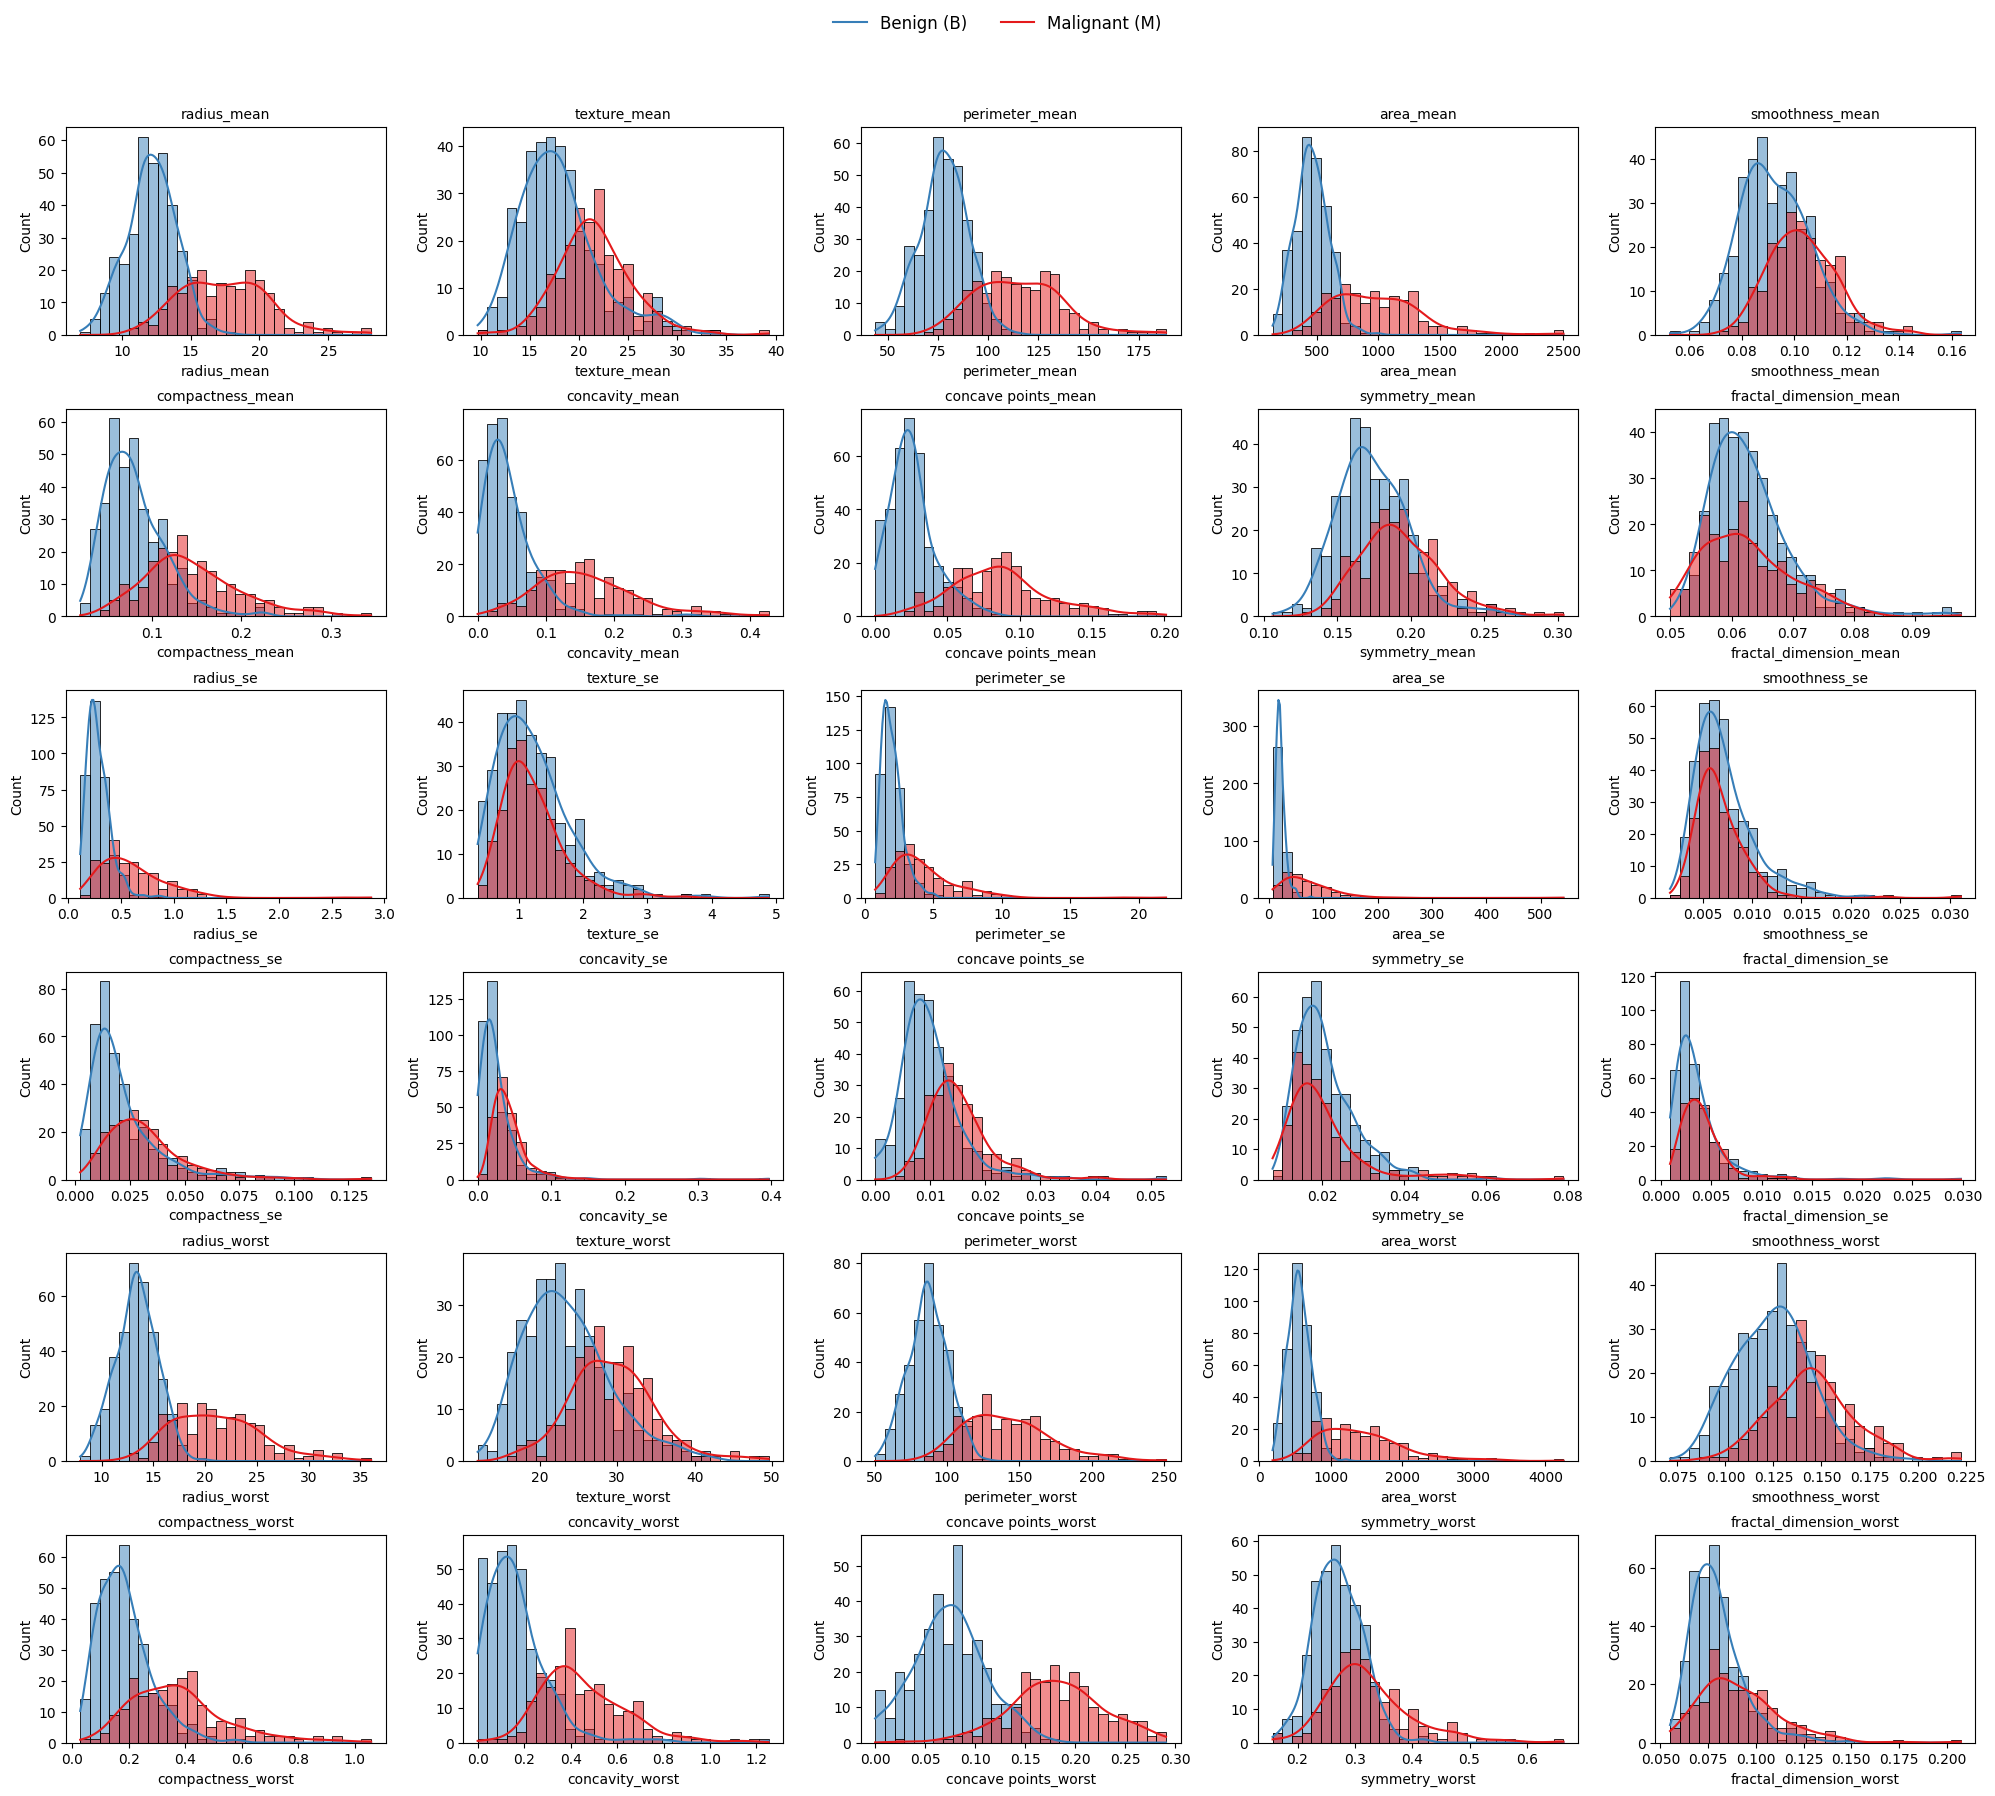

In [ ]:
# All feature columns except the target
features = df.drop("diagnosis", axis=1).columns
n_features = len(features)

# Grid: 5 columns, enough rows to fit all features
n_cols = 5
n_rows = math.ceil(n_features / n_cols)
plt.figure(figsize=(20, n_rows*3))

for i, col in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=df, x=col, hue="diagnosis", bins=30, kde=True, palette="Set1", legend=False)
    plt.title(col, fontsize=10)

plt.tight_layout()

# Add one global legend
plt.figlegend(labels=["Benign (B)", "Malignant (M)"], loc="upper center", ncol=2, frameon=False, fontsize=12)
plt.subplots_adjust(top=0.93)  # leave space for legend
plt.show()

**correlation heatmap**

In [ ]:
# Encode diagnosis: B=0 (benign), M=1 (malignant)
df_encoded = df.copy()
df_encoded["diagnosis"] = df_encoded["diagnosis"].map({"B":0, "M":1})

In [ ]:
def compute_correlations(df, target="diagnosis", threshold=0.9):
    corr_matrix = df.corr().abs()

    # 1. Redundant pairs
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    redundant_features = [(col, row, upper.loc[row, col])
                          for col in upper.columns
                          for row in upper.index
                          if upper.loc[row, col] > threshold]
    # 2. Correlation with target
    corr_with_target = corr_matrix[target].drop(target).sort_values(ascending=False)

    return redundant_features, corr_with_target

In [ ]:
# Assuming your function outputs
redundant, corr_with_target = compute_correlations(df_encoded)

# Create folder if it doesn't exist
os.makedirs("results/tables", exist_ok=True)

# Convert redundant correlations to DataFrame for saving
redundant_df = pd.DataFrame(redundant, columns=["Feature_1", "Feature_2", "Correlation"])

print("Highly correlated feature pairs (>0.9):")
for f1, f2, val in redundant:
    print(f"{f1} ↔ {f2} : {val:.2f}")

# Save to CSV file
file_path = "results/tables/redundant_features.csv"
redundant_df.to_csv(file_path, index=False)

print(f"Saved highly correlated feature/redundant pairs to {file_path}")

Highly correlated feature pairs (>0.9):
perimeter_mean ↔ radius_mean : 1.00
area_mean ↔ radius_mean : 0.99
area_mean ↔ perimeter_mean : 0.99
concave points_mean ↔ concavity_mean : 0.92
perimeter_se ↔ radius_se : 0.97
area_se ↔ radius_se : 0.95
area_se ↔ perimeter_se : 0.94
radius_worst ↔ radius_mean : 0.97
radius_worst ↔ perimeter_mean : 0.97
radius_worst ↔ area_mean : 0.96
texture_worst ↔ texture_mean : 0.91
perimeter_worst ↔ radius_mean : 0.97
perimeter_worst ↔ perimeter_mean : 0.97
perimeter_worst ↔ area_mean : 0.96
perimeter_worst ↔ radius_worst : 0.99
area_worst ↔ radius_mean : 0.94
area_worst ↔ perimeter_mean : 0.94
area_worst ↔ area_mean : 0.96
area_worst ↔ radius_worst : 0.98
area_worst ↔ perimeter_worst : 0.98
concave points_worst ↔ concave points_mean : 0.91
Saved highly correlated feature/redundant pairs to results/tables/redundant_features.csv


In [ ]:
# Print top 10 features predictive of diagnosis
print("\nTop 10 features predictive of diagnosis:")
print(corr_with_target.head(10))

# Create folder if it doesn't exist
os.makedirs("results/tables", exist_ok=True)

# Save top 10 features to CSV
top_10_df = corr_with_target.head(10)
file_path = "results/tables/top_10_predictive_features.csv"
top_10_df.to_csv(file_path)

print(f"Top 10 predictive features saved to {file_path}")

# Save top 10 feature data into X_top
top_10_features = top_10_df.index.tolist()
X_top = df[top_10_features]   # DataFrame with top features
top_features = X_top.columns  # Index of feature names
print(top_features)


Top 10 features predictive of diagnosis:
concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
concavity_mean          0.696360
concavity_worst         0.659610
Name: diagnosis, dtype: float64
Top 10 predictive features saved to results/tables/top_10_predictive_features.csv
Index(['concave points_worst', 'perimeter_worst', 'concave points_mean',
       'radius_worst', 'perimeter_mean', 'area_worst', 'radius_mean',
       'area_mean', 'concavity_mean', 'concavity_worst'],
      dtype='object')


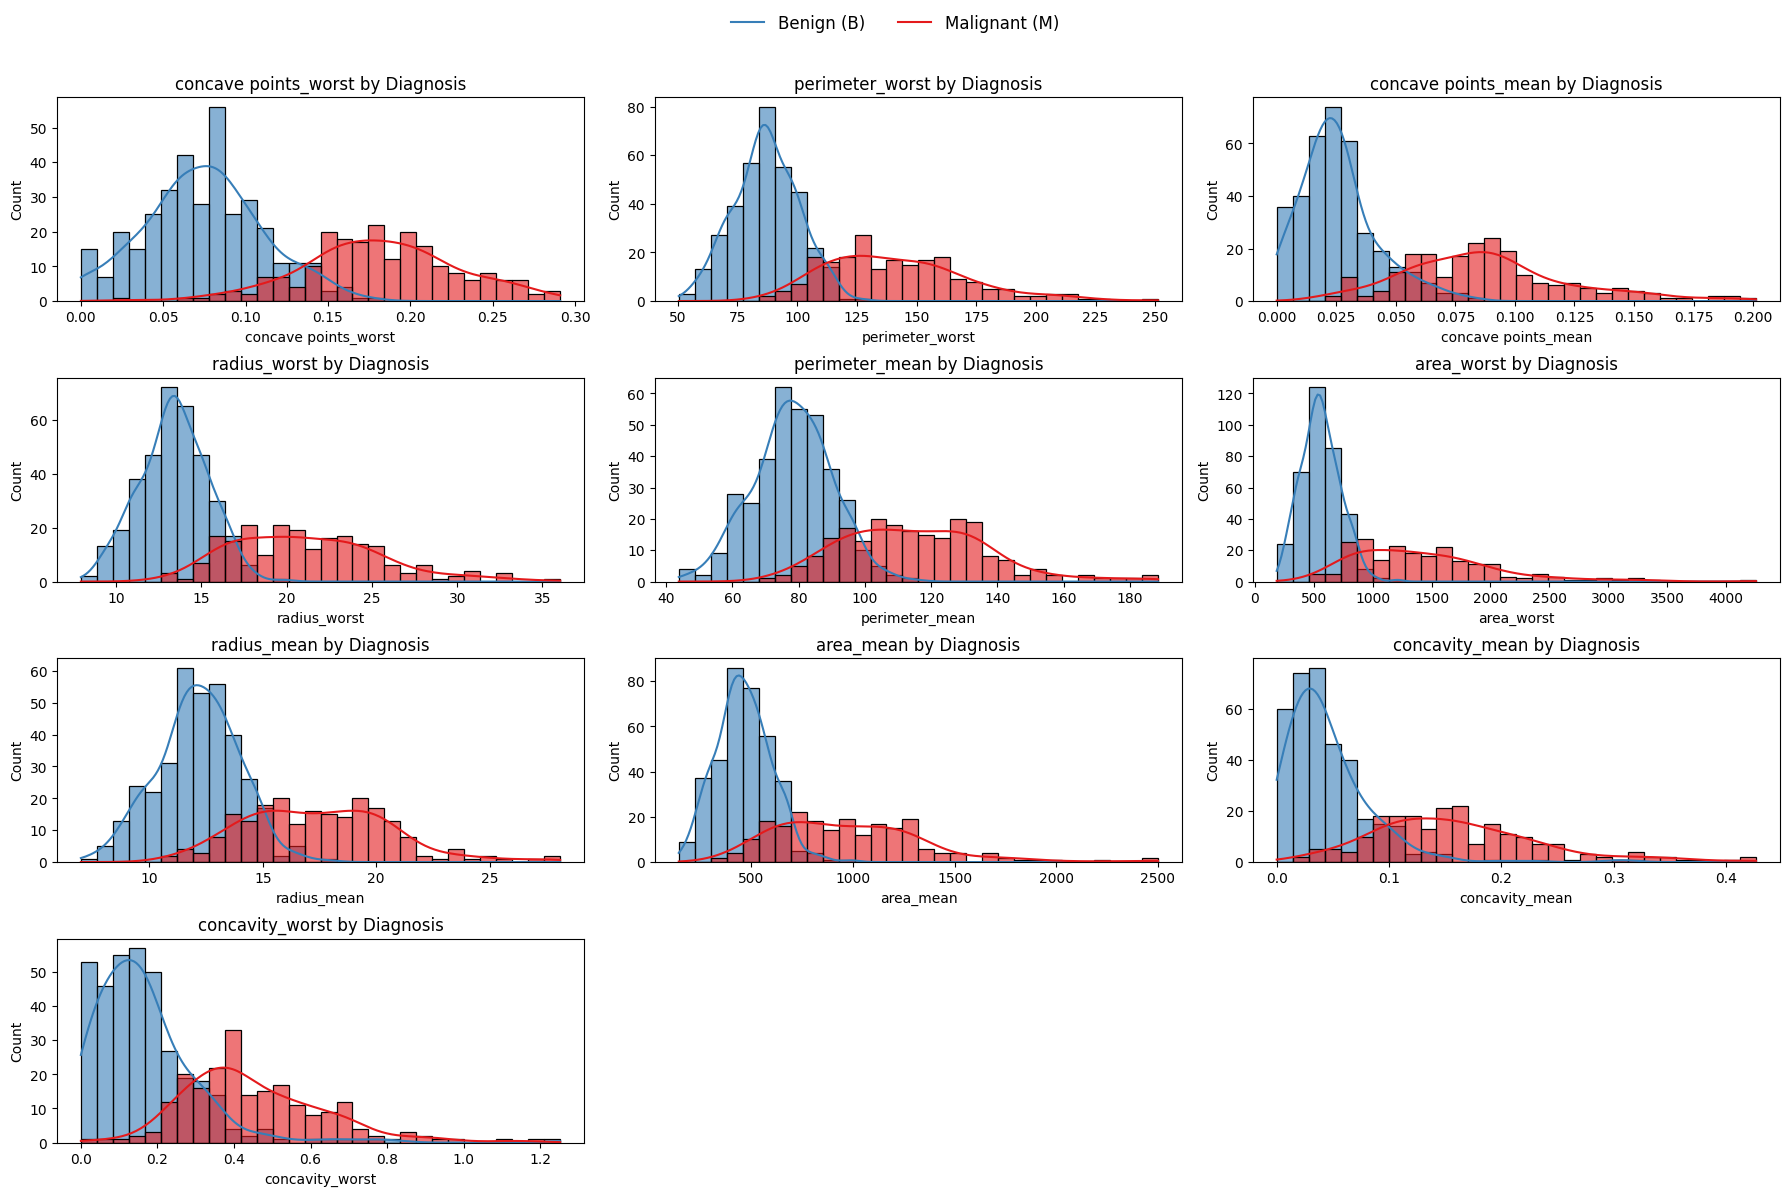

In [ ]:
# Create the plots directory if it doesn't exist
os.makedirs("results/plots", exist_ok=True)

n_features = len(top_features)

plt.figure(figsize=(18, 12))

for i, col in enumerate(top_features, 1):
    plt.subplot(4, 3, i)  # 4 rows, 3 cols
    sns.histplot(data=df, x=col, hue="diagnosis", bins=30, kde=True, palette="Set1", alpha=0.6, legend=False)
    plt.title(f"{col} by Diagnosis")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.figlegend(labels=["Benign (B)", "Malignant (M)"], loc="upper center", ncol=2, frameon=False, fontsize=12)
plt.subplots_adjust(top=0.92)  # leave space for legend

# Save the plot as PNG in "plots" folder
plt.savefig("results/plots/top_10_features_histograms.png", dpi=300, bbox_inches="tight")

plt.show()

**PCA for visualization**

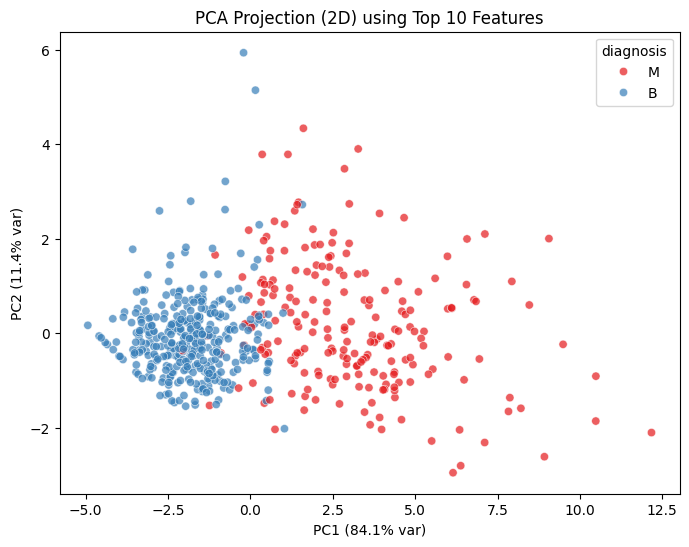

Explained variance ratio: [0.84148202 0.11423637]
Total variance explained: 0.9557183910746991


In [ ]:
# Ensure plots folder exists
os.makedirs("results/plots", exist_ok=True)

# Step 4: Scale top features
X_scaled_top = StandardScaler().fit_transform(X_top)
y = df["diagnosis"]

# Step 5: PCA with top 10
pca = PCA(n_components=2)
X_pca_top = pca.fit_transform(X_scaled_top)

# Step 6: Visualization
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca_top[:,0], y=X_pca_top[:,1], hue=y, palette="Set1", alpha=0.7)
plt.title("PCA Projection (2D) using Top 10 Features")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")

# Save figure to PNG file
plt.savefig("results/plots/pca_top_10_features.png", dpi=300, bbox_inches="tight")

plt.show()

# Step 7: Report variance explained
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained:", sum(pca.explained_variance_ratio_))

**t-SNE or UMAP**
better visualization of clusters and often show separation of benign vs malignant more clearly than PCA.

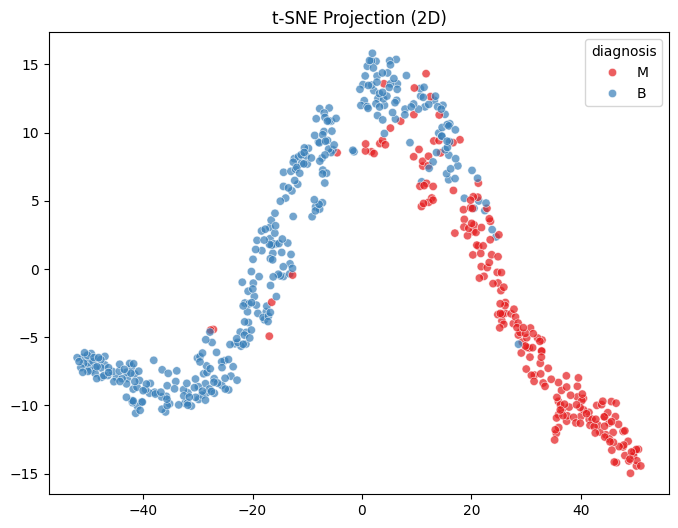

In [ ]:
# Ensure "plots" directory exists
os.makedirs("results/plots", exist_ok=True)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_top)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette="Set1", alpha=0.7)
plt.title("t-SNE Projection (2D)")

# Save the plot as PNG
plt.savefig("results/plots/tsne_projection.png", dpi=300, bbox_inches="tight")

plt.show()

**Modeling**

**Train-test split**

In [ ]:
# Use only top 10 features
X = X_top
y = df_encoded["diagnosis"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Utility Functions

In [ ]:
# Threshold evaluation
def evaluate_thresholds_all(model, X_test, y_test, step=0.001):
    y_probs = model.predict_proba(X_test)[:, 1]
    thresholds = np.round(np.arange(0, 1.0001, step), 3)
    rows = []
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision   = precision_score(y_test, y_pred, zero_division=0)
        recall      = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        beta = 2
        f2 = (1+beta**2) * (precision*recall) / ((beta**2 * precision) + recall) if (precision+recall) > 0 else 0
        youden = sensitivity + specificity - 1
        rows.append((t, sensitivity, specificity, precision, recall, f1, f2, youden))
    return pd.DataFrame(rows, columns=["threshold","sensitivity","specificity","precision","recall","f1","f2","youden"])


In [ ]:
# Helper to pick best threshold by metric
def best_threshold_by(df, metric):
    return df.loc[df[metric].idxmax()]

In [ ]:
# Plotting metrics vs threshold
def plot_threshold_metrics(df, bests, model_name, save_dir=None):
    plt.figure(figsize=(10,5))
    plt.plot(df.threshold, df.youden, label="Youden's J")
    plt.plot(df.threshold, df.f2,   label="F2-score")
    plt.plot(df.threshold, df.f1,   label="F1-score")

    # Mark chosen thresholds
    for best, name, color in [(bests["youden"], "Youden", "tab:red"),
                              (bests["f2"], "F2", "tab:orange"),
                              (bests["f1"], "F1", "tab:green")]:
        plt.axvline(best.threshold, color=color, linestyle="--", alpha=0.8)
        plt.text(best.threshold+0.005, best[name.lower() if name!="Youden" else "youden"],
                 f"{name}={best.threshold:.3f}", color=color, fontsize=9, fontweight="bold",
                 rotation=90, va="bottom")

    plt.xlabel("Threshold")
    plt.ylabel("Metric Value")
    plt.title(f"{model_name} - Threshold Optimization (Youden / F2 / F1)")
    plt.legend()
    plt.grid(alpha=0.25)

        # Save the plot BEFORE plt.show()
    if save_dir:
        plt.savefig(f"{save_dir}/{model_name}_threshold_metrics.png",
                    dpi=300, bbox_inches='tight')
    plt.show()




Single-Split Workflow

In [ ]:
def run_model_workflow(model, model_name, X_train, y_train, X_test, y_test, feature_names=None, save_dir="results/model_outputs"):
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)

    # Train
    model.fit(X_train, y_train)

    # Evaluate thresholds
    df = evaluate_thresholds_all(model, X_test, y_test)
    bests = {
        "youden": best_threshold_by(df, "youden"),
        "f1": best_threshold_by(df, "f1"),
        "f2": best_threshold_by(df, "f2")
    }

    # Save threshold evaluation results
    df.to_csv(f"{save_dir}/{model_name}_threshold_evaluation.csv", index=False)

    # Save best thresholds summary
    best_thresholds_df = pd.DataFrame([
        {"metric": k.upper(), "threshold": v.threshold, "precision": v.precision,
         "recall": v.recall, "score": v[k]} for k, v in bests.items()
    ])
    best_thresholds_df.to_csv(f"{save_dir}/{model_name}_best_thresholds.csv", index=False)

    # Print best thresholds (console output unchanged)
    print(f"\nBest thresholds ({model_name}):")
    for k, v in bests.items():
        print(f"{k.upper()}: thr={v.threshold:.3f}, prec={v.precision:.3f}, rec={v.recall:.3f}, {k}={v[k]:.3f}")

    # Plot threshold curves
    plot_threshold_metrics(df, bests, model_name, save_dir=save_dir)
    # Save the plot (assuming plot_threshold_metrics creates a current figure)
    # REMOVED plt.savefig(f"{save_dir}/{model_name}_threshold_metrics.png", dpi=300, bbox_inches='tight')


    # Final evaluation (at Youden)
    final_thresh = bests["youden"].threshold
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= final_thresh).astype(int)

    # Save confusion matrix and classification report
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, digits=3, output_dict=True)

    # Save confusion matrix as CSV
    cm_df = pd.DataFrame(cm, index=['Actual_0', 'Actual_1'], columns=['Pred_0', 'Pred_1'])
    cm_df.to_csv(f"{save_dir}/{model_name}_confusion_matrix.csv")

    # Save classification report as CSV
    cr_df = pd.DataFrame(cr).transpose()
    cr_df.to_csv(f"{save_dir}/{model_name}_classification_report.csv")

    # Console output unchanged
    print(f"\nFinal Confusion Matrix ({model_name}, thr={final_thresh:.3f}):")
    print(confusion_matrix(y_test, y_pred))
    print("\nFinal Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    # -----------------------------
    # ROC + Precision-Recall with threshold marker
    # -----------------------------
    y_probs = model.predict_proba(X_test)[:, 1]  # works for all models wrapped in Pipeline

    fpr, tpr, roc_thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    idx = (roc_thresholds >= final_thresh).argmax()

    prec, rec, pr_thresholds = precision_recall_curve(y_test, y_probs)
    idx_pr = (pr_thresholds >= final_thresh).argmax()

    # Save ROC and PR curve data
    roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': roc_thresholds})
    roc_df.to_csv(f"{save_dir}/{model_name}_roc_curve_data.csv", index=False)

    pr_df = pd.DataFrame({'precision': prec, 'recall': rec, 'thresholds': list(pr_thresholds) + [1.0]})  # PR has n-1 thresholds
    pr_df.to_csv(f"{save_dir}/{model_name}_pr_curve_data.csv", index=False)

    plt.figure(figsize=(12, 5))

    # ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC={roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.scatter(fpr[idx], tpr[idx], color="red", zorder=5)
    plt.axvline(fpr[idx], color="red", linestyle="--")
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    # PR
    plt.subplot(1, 2, 2)
    plt.plot(rec, prec, label="PR curve")
    if idx_pr < len(pr_thresholds):  # ensure threshold index is valid
        plt.scatter(rec[idx_pr], prec[idx_pr], color="red", zorder=5)
        plt.axhline(y=prec[idx_pr], color="green", linestyle="--")
        plt.axvline(x=rec[idx_pr], color="red", linestyle="--")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    plt.tight_layout()
    # Save the ROC/PR plot
    plt.savefig(f"{save_dir}/{model_name}_roc_pr_curves.png", dpi=300, bbox_inches='tight')
    plt.show()

    # -----------------------------
    # Random Forest Feature Importances
    # -----------------------------
    if "Forest" in model_name:
        # If it's a pipeline, get the final estimator
        clf = model.named_steps["clf"] if hasattr(model, "named_steps") else model

        if hasattr(clf, "feature_importances_"):
            importances = pd.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=False)

            # Save feature importances
            importances.to_csv(f"{save_dir}/{model_name}_feature_importances.csv", header=['importance'])

            plt.figure(figsize=(8, 5))
            sns.barplot(x=importances.values, y=importances.index, hue=importances.index,
                        palette="viridis", dodge=False, legend=False)
            plt.title(f"{model_name} - Feature Importances")
            plt.xlabel("Importance Score")
            plt.ylabel("Feature")
            # Save the plot
            plt.savefig(f"{save_dir}/{model_name}_feature_importances_plot.png", dpi=300, bbox_inches='tight')
            plt.show()

            # Console output unchanged
            print("\nTop 5 Most Important Features:")
            print(importances.head(5).to_string())

    # -----------------------------
    # Logistic Regression - Coefficients
    # -----------------------------
    if "Logistic" in model_name:
        clf = model.named_steps["clf"] if hasattr(model, "named_steps") else model

        if hasattr(clf, "coef_"):
            log_reg_importances = pd.Series(clf.coef_[0], index=feature_names).sort_values(ascending=False)

            N = 5
            abs_importances = log_reg_importances.abs().sort_values(ascending=False)
            top_features = abs_importances.head(N).index.tolist()

            summary = pd.DataFrame({
                "Feature": top_features,
                "Coefficient": log_reg_importances[top_features],
                "Effect": ["Risk ↑" if log_reg_importances[f] > 0 else "Protective ↓" for f in top_features]
            }).sort_values(by="Coefficient", ascending=False)

            # Save logistic regression results
            log_reg_importances.to_csv(f"{save_dir}/{model_name}_coefficients.csv", header=['coefficient'])
            summary.to_csv(f"{save_dir}/{model_name}_top_predictors.csv", index=False)

            # Console output unchanged
            print(f"\nTop {N} Most Important Predictors:\n")
            print(summary.to_string(index=False))

            # Plot
            plt.figure(figsize=(8, 5))
            colors = ["red" if f in top_features else "blue" for f in log_reg_importances.index]
            plt.barh(log_reg_importances.index, log_reg_importances.values, color=colors)

            # Annotate key features
            for i, (val, feature) in enumerate(zip(log_reg_importances.values, log_reg_importances.index)):
                if feature in top_features:
                    annotation = "  key" + (" (protective)" if val < 0 else " (risk ↑)")
                    plt.text(val, i, annotation, color="red", va="center", fontweight="bold")

            plt.title(f"Logistic Regression - Feature Importances (Top {N} highlighted)")
            plt.xlabel("Coefficient Value")
            plt.ylabel("Feature")
            plt.gca().invert_yaxis()
            # Save the plot
            plt.savefig(f"{save_dir}/{model_name}_logistic_coefficients_plot.png", dpi=300, bbox_inches='tight')
            plt.show()

    # -----------------------------
    # XGBoost (gain importance)
    # -----------------------------
    if "XGB" in model_name:
        try:
            # Unwrap final estimator if this is a pipeline
            clf = model
            if hasattr(model, "named_steps"):  # typical pipeline attribute
                clf = model.named_steps.get("clf", model)

            booster = None
            if hasattr(clf, "get_booster"):
                booster = clf.get_booster()

            if booster:
                importance_dict = booster.get_score(importance_type="gain")
            else:
                importance_dict = {}

            # Fallback if no booster or empty dict but feature_importances_ exist
            if not importance_dict and hasattr(clf, "feature_importances_"):
                importance_dict = {f: imp for f, imp in zip(feature_names, clf.feature_importances_)}

            if importance_dict:
                importances = pd.DataFrame.from_dict(
                    importance_dict, orient="index", columns=["importance"]
                )
                importances.sort_values("importance", ascending=True, inplace=True)

                # Save XGBoost importances
                importances.to_csv(f"{save_dir}/{model_name}_xgb_importances.csv")

                # Plot
                plt.figure(figsize=(8, 6))
                sns.barplot(x=importances["importance"], y=importances.index, hue=importances.index,
                    palette="viridis", dodge=False, legend=False)
                plt.title(f"{model_name} Feature Importances (Gain)")
                plt.xlabel("Gain Importance")
                plt.ylabel("Feature")
                # Save the plot
                plt.savefig(f"{save_dir}/{model_name}_xgb_importances_plot.png", dpi=300, bbox_inches='tight')
                plt.show()

                # Console output unchanged
                print("\nTop 5 Most Important Features (XGB):")
                print(importances.tail(5).to_string())
            else:
                print(f"⚠️ No feature importances available for {model_name}.")
        except Exception as e:
            print(f"Could not extract feature importances: {e}")

    print(f"\n✅ All results and plots saved to '{save_dir}/' directory")

Stratified K-Fold Workflow (e.g. for XGBoost)

In [ ]:
# Stratified K-Fold Workflow (e.g. for XGBoost)
def run_model_workflow_cv(model, model_name, X, y, n_splits=5, step=0.01, feature_names=None, save_dir="results/model_outputs_cv"):
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    metrics_list = []
    probs_all, y_all = [], []
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_probs = model.predict_proba(X_val)[:,1]
        probs_all.extend(y_probs)
        y_all.extend(y_val)

        df = evaluate_thresholds_all(model, X_val, y_val, step=step)
        metrics_list.append(df)

        # Store fold-specific results
        fold_results.append({
            'fold': fold,
            'train_size': len(train_idx),
            'val_size': len(val_idx),
            'val_probs': y_probs,
            'val_true': y_val.values
        })

    # Save fold-level results
    fold_summary = pd.DataFrame([{
        'fold': fr['fold'],
        'train_size': fr['train_size'],
        'val_size': fr['val_size']
    } for fr in fold_results])
    fold_summary.to_csv(f"{save_dir}/{model_name}_cv_fold_summary.csv", index=False)

    # Aggregate metrics
    df_all = pd.concat(metrics_list).groupby("threshold").mean().reset_index()

    # Save aggregated threshold metrics
    df_all.to_csv(f"{save_dir}/{model_name}_cv_threshold_evaluation.csv", index=False)

    bests = {
        "youden": best_threshold_by(df_all, "youden"),
        "f1": best_threshold_by(df_all, "f1"),
        "f2": best_threshold_by(df_all, "f2")
    }

    # Save best thresholds summary
    best_thresholds_df = pd.DataFrame([
        {"metric": k.upper(), "threshold": v.threshold, "precision": v.precision,
         "recall": v.recall, "score": v[k]} for k, v in bests.items()
    ])
    best_thresholds_df.to_csv(f"{save_dir}/{model_name}_cv_best_thresholds.csv", index=False)

    # Print best thresholds (console output unchanged)
    print(f"\nBest thresholds ({model_name}, {n_splits}-fold CV):")
    for k,v in bests.items():
        print(f"{k.upper()}: thr={v.threshold:.3f}, prec={v.precision:.3f}, rec={v.recall:.3f}, {k}={v[k]:.3f}")

    # Plot metrics vs threshold
    plot_threshold_metrics(df_all, bests, f"{model_name}_cv", save_dir=save_dir)

    # Save the plot (assuming plot_threshold_metrics creates a current figure)
    # Removed plt.savefig(f"{save_dir}/{model_name}_cv_threshold_metrics.png", dpi=300, bbox_inches='tight')

    # Final eval on all folds (at Youden)
    final_thresh = bests["youden"].threshold
    y_pred = (np.array(probs_all) >= final_thresh).astype(int)

    # Save confusion matrix and classification report
    cm = confusion_matrix(y_all, y_pred)
    cr = classification_report(y_all, y_pred, digits=3, output_dict=True)

    # Save confusion matrix as CSV
    cm_df = pd.DataFrame(cm, index=['Actual_0', 'Actual_1'], columns=['Pred_0', 'Pred_1'])
    cm_df.to_csv(f"{save_dir}/{model_name}_cv_confusion_matrix.csv")

    # Save classification report as CSV
    cr_df = pd.DataFrame(cr).transpose()
    cr_df.to_csv(f"{save_dir}/{model_name}_cv_classification_report.csv")

    # Save all predictions and probabilities
    cv_predictions = pd.DataFrame({
        'y_true': y_all,
        'y_prob': probs_all,
        'y_pred': y_pred
    })
    cv_predictions.to_csv(f"{save_dir}/{model_name}_cv_predictions.csv", index=False)

    # Console output unchanged
    print(f"\nFinal Confusion Matrix ({model_name}, thr={final_thresh:.3f}):")
    print(confusion_matrix(y_all, y_pred))
    print("\nFinal Classification Report:")
    print(classification_report(y_all, y_pred, digits=3))

    # ROC + Precision-Recall with threshold marker
    fpr, tpr, roc_thresholds = roc_curve(y_all, probs_all)
    roc_auc = auc(fpr, tpr)
    idx_roc = (roc_thresholds >= final_thresh).argmax()

    prec, rec, pr_thresholds = precision_recall_curve(y_all, probs_all)
    idx_pr = (pr_thresholds >= final_thresh).argmax()

    # Save ROC and PR curve data
    roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': roc_thresholds})
    roc_df.to_csv(f"{save_dir}/{model_name}_cv_roc_curve_data.csv", index=False)

    pr_df = pd.DataFrame({'precision': prec, 'recall': rec, 'thresholds': list(pr_thresholds) + [1.0]})  # PR has n-1 thresholds
    pr_df.to_csv(f"{save_dir}/{model_name}_cv_pr_curve_data.csv", index=False)

    plt.figure(figsize=(12,5))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.scatter(fpr[idx_roc], tpr[idx_roc], color="red", zorder=5)
    plt.axvline(fpr[idx_roc], color="red", linestyle="--")
    plt.title(f"ROC Curve - {model_name} (CV)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    # PR
    plt.subplot(1,2,2)
    plt.plot(rec, prec, label="PR curve")
    if idx_pr < len(pr_thresholds):
        plt.scatter(rec[idx_pr], prec[idx_pr], color="red", zorder=5)
        plt.axhline(y=prec[idx_pr], color="green", linestyle="--")
        plt.axvline(x=rec[idx_pr], color="red", linestyle="--")
    plt.title(f"Precision-Recall Curve - {model_name} (CV)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    plt.tight_layout()
    # Save the ROC/PR plot
    plt.savefig(f"{save_dir}/{model_name}_cv_roc_pr_curves.png", dpi=300, bbox_inches='tight')
    plt.show()

    # ========================================================
    # Feature Importances (for XGBoost)
    # ========================================================
    if "XGB" in model_name:
        try:
            # Unwrap final estimator if this is a pipeline
            clf = model
            if hasattr(model, "named_steps"):  # typical pipeline attribute
                clf = model.named_steps.get("clf", model)

            booster = None
            if hasattr(clf, "get_booster"):
                booster = clf.get_booster()

            if booster:
                importance_dict = booster.get_score(importance_type="gain")
            else:
                importance_dict = {}

            # Fallback if no booster or empty dict but feature_importances_ exist
            if not importance_dict and hasattr(clf, "feature_importances_"):
                importance_dict = {f: imp for f, imp in zip(feature_names, clf.feature_importances_)}

            if importance_dict:
                importances = pd.DataFrame.from_dict(
                    importance_dict, orient="index", columns=["importance"]
                )
                importances.sort_values("importance", ascending=True, inplace=True)

                # Save XGBoost importances
                importances.to_csv(f"{save_dir}/{model_name}_cv_xgb_importances.csv")

                # Plot
                plt.figure(figsize=(8, 6))
                sns.barplot(x=importances["importance"], y=importances.index, hue=importances.index,
                        palette="viridis", dodge=False, legend=False)
                plt.title(f"{model_name} Feature Importances (Gain)")
                plt.xlabel("Gain Importance")
                plt.ylabel("Feature")
                # Save the plot
                plt.savefig(f"{save_dir}/{model_name}_cv_xgb_importances_plot.png", dpi=300, bbox_inches='tight')
                plt.show()

                # Console output unchanged
                print("\nTop 5 Most Important Features (XGB):")
                print(importances.tail(5).to_string())
            else:
                print(f"⚠️ No feature importances available for {model_name}.")
        except Exception as e:
            print(f"Could not extract feature importances: {e}")

    print(f"\n✅ All CV results and plots saved to '{save_dir}/' directory")



Logistic Regression Workflow


Best thresholds (Logistic Regression):
YOUDEN: thr=0.355, prec=0.933, rec=1.000, youden=0.958
F1: thr=0.355, prec=0.933, rec=1.000, f1=0.966
F2: thr=0.355, prec=0.933, rec=1.000, f2=0.986


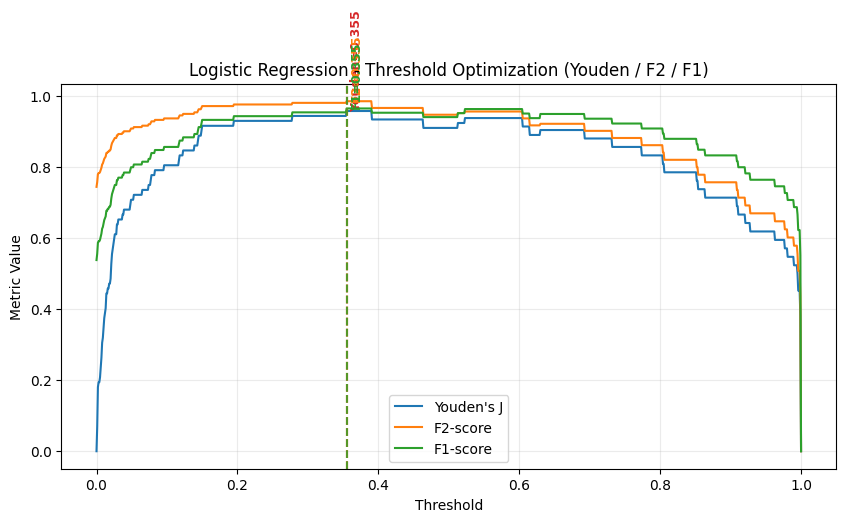


Final Confusion Matrix (Logistic Regression, thr=0.355):
[[69  3]
 [ 0 42]]

Final Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.958     0.979        72
           1      0.933     1.000     0.966        42

    accuracy                          0.974       114
   macro avg      0.967     0.979     0.972       114
weighted avg      0.975     0.974     0.974       114



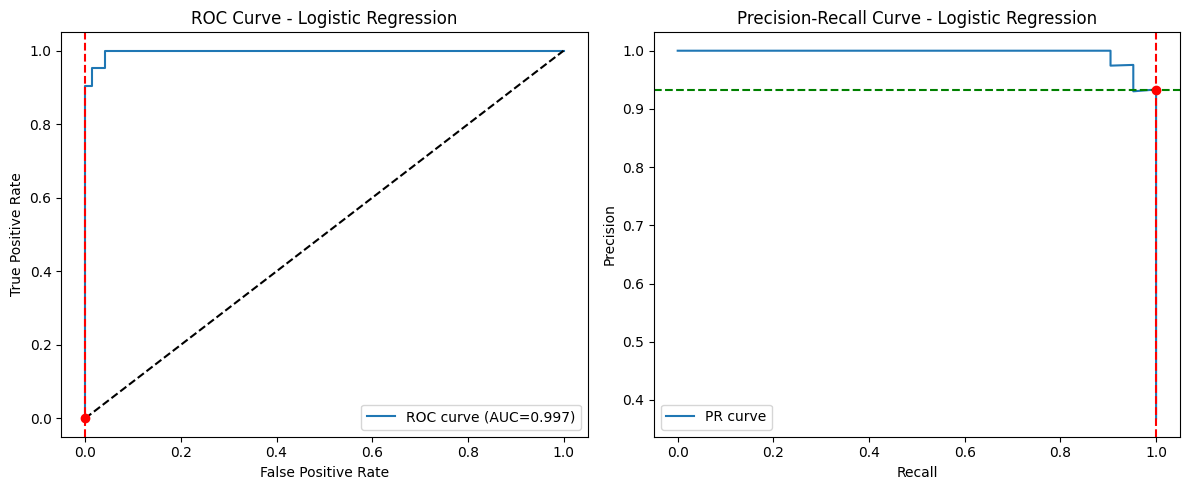


Top 5 Most Important Predictors:

             Feature  Coefficient Effect
          area_worst     1.862988 Risk ↑
        radius_worst     1.765171 Risk ↑
 concave points_mean     1.190969 Risk ↑
     perimeter_worst     1.133170 Risk ↑
concave points_worst     1.073927 Risk ↑


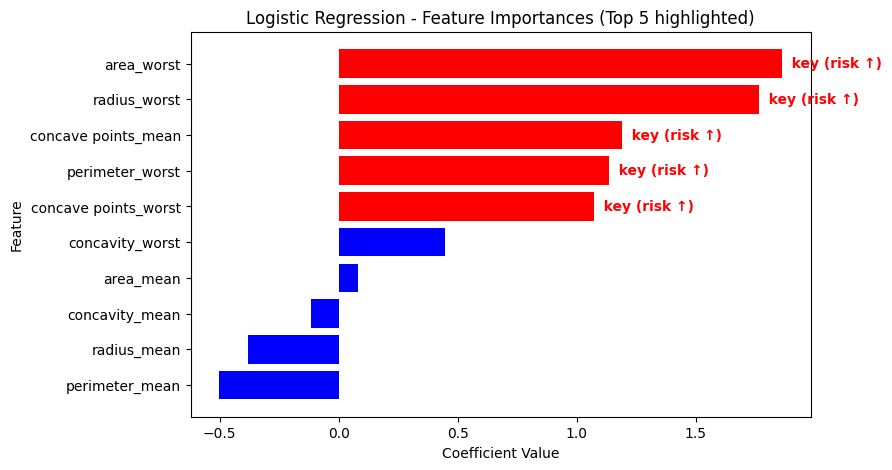


✅ All results and plots saved to 'results/model_outputs/' directory


In [ ]:
lr_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])
run_model_workflow(lr_model, "Logistic Regression", X_train, y_train, X_test, y_test, feature_names=X_train.columns)

Random Forest Workflow


Best thresholds (Random Forest):
YOUDEN: thr=0.451, prec=1.000, rec=0.929, youden=0.929
F1: thr=0.451, prec=1.000, rec=0.929, f1=0.963
F2: thr=0.111, prec=0.857, rec=1.000, f2=0.968


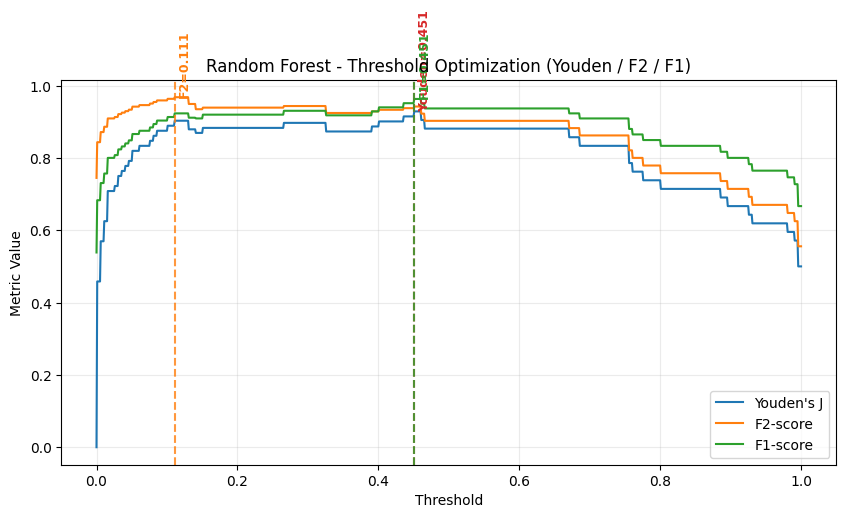


Final Confusion Matrix (Random Forest, thr=0.451):
[[72  0]
 [ 3 39]]

Final Classification Report:
              precision    recall  f1-score   support

           0      0.960     1.000     0.980        72
           1      1.000     0.929     0.963        42

    accuracy                          0.974       114
   macro avg      0.980     0.964     0.971       114
weighted avg      0.975     0.974     0.973       114



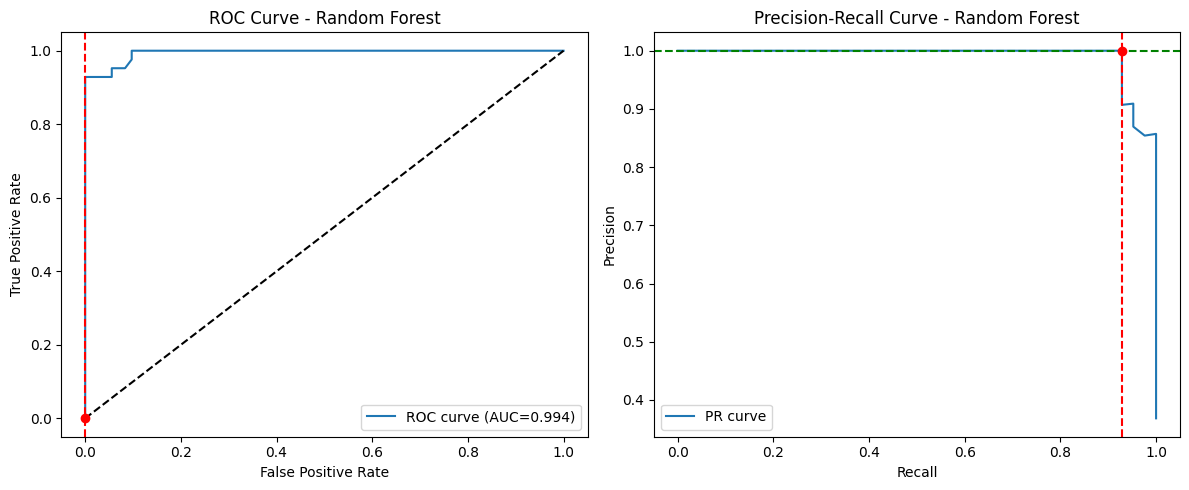

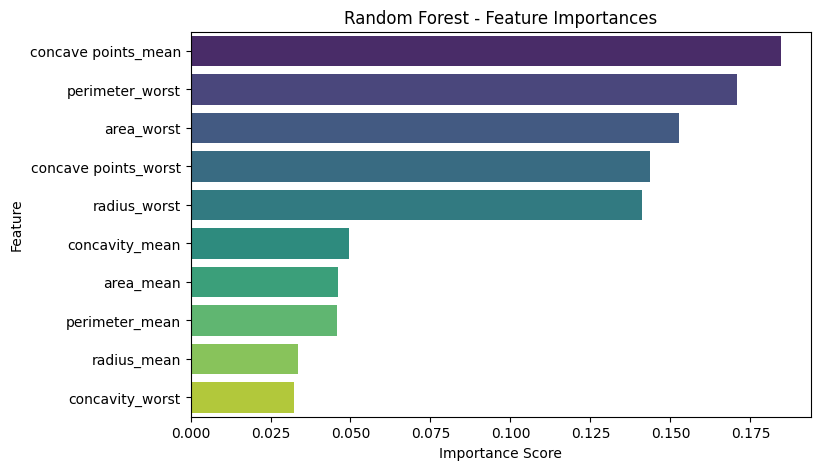


Top 5 Most Important Features:
concave points_mean     0.184565
perimeter_worst         0.170673
area_worst              0.152693
concave points_worst    0.143771
radius_worst            0.141043

✅ All results and plots saved to 'results/model_outputs/' directory


In [ ]:
# Random Forest Workflow
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)
run_model_workflow(rf_model, "Random Forest", X_train, y_train, X_test, y_test, feature_names=X_train.columns)

XGBoost Workflow (with Stratified K-Fold CV)


Best thresholds (XGBoost, 5-fold CV):
YOUDEN: thr=0.470, prec=0.930, rec=0.925, youden=0.883
F1: thr=0.700, prec=0.955, rec=0.901, f1=0.927
F2: thr=0.060, prec=0.841, rec=0.962, f2=0.935


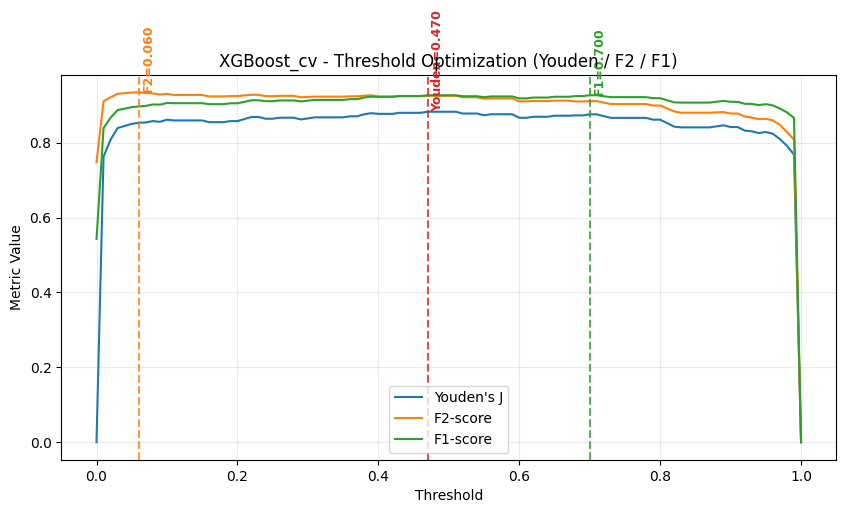


Final Confusion Matrix (XGBoost, thr=0.470):
[[342  15]
 [ 16 196]]

Final Classification Report:
              precision    recall  f1-score   support

           0      0.955     0.958     0.957       357
           1      0.929     0.925     0.927       212

    accuracy                          0.946       569
   macro avg      0.942     0.941     0.942       569
weighted avg      0.945     0.946     0.945       569



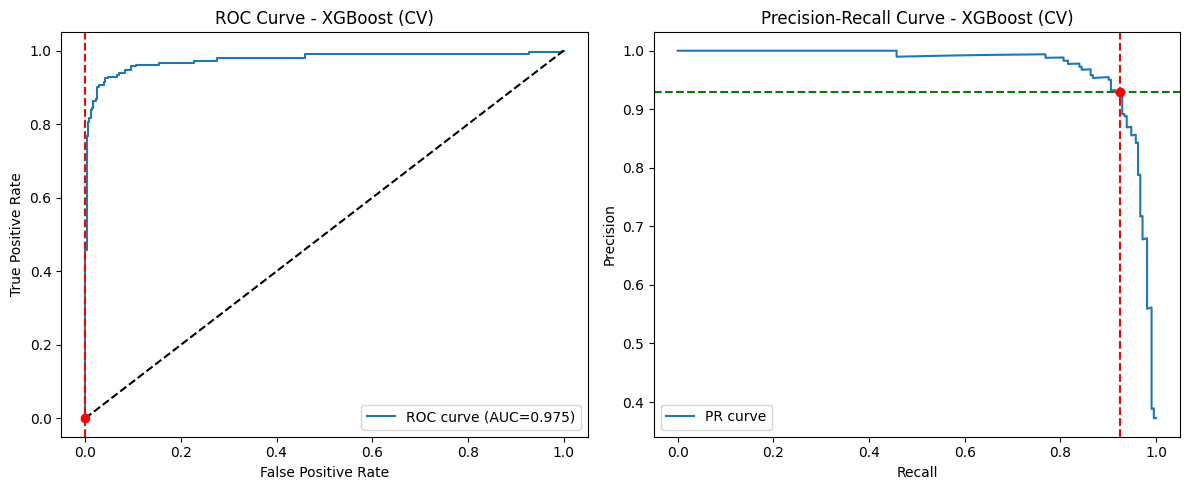

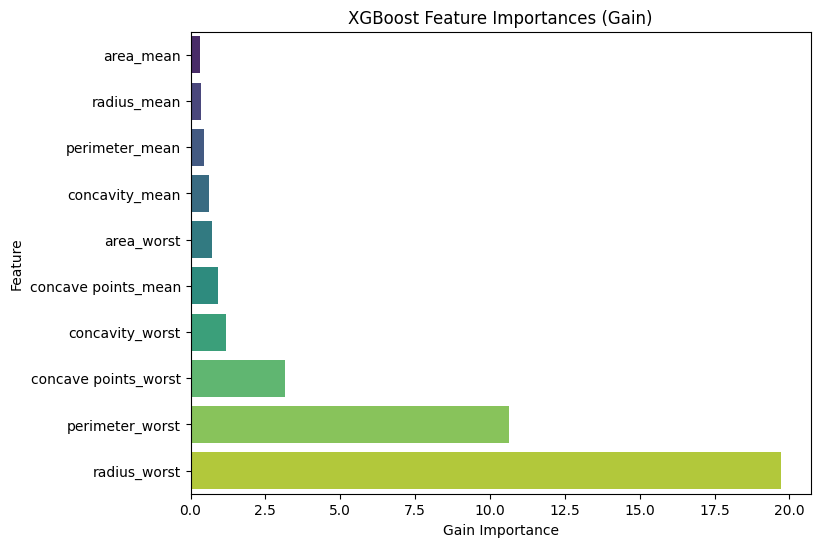


Top 5 Most Important Features (XGB):
                      importance
concave points_mean     0.905758
concavity_worst         1.172870
concave points_worst    3.145377
perimeter_worst        10.643685
radius_worst           19.720589

✅ All CV results and plots saved to 'results/model_outputs_cv/' directory


In [ ]:
# XGBoost Workflow (with Stratified K-Fold CV)
xgb_params = {
    "n_estimators": 200,
    "max_depth": 4,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "scale_pos_weight": (y_train.value_counts()[0] / y_train.value_counts()[1])
}

xgb_model = xgb.XGBClassifier(eval_metric="logloss")

run_model_workflow_cv(xgb_model, "XGBoost", X, y, n_splits=5, step=0.01)


Hyerparameter tuning

Logistic Regression Tuning

In [ ]:
# 1. Logistic Regression
# -----------------------------
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42))
])

lr_param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["saga", "lbfgs"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr_grid = GridSearchCV(
    lr_pipeline, lr_param_grid, scoring="roc_auc",
    cv=cv, n_jobs=-1, verbose=1
)
lr_grid.fit(X_train, y_train)

print("Best Logistic Regression Params:", lr_grid.best_params_)
print("Best ROC-AUC:", lr_grid.best_score_)

best_lr = lr_grid.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Logistic Regression Params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Best ROC-AUC: 0.9860681114551084


Random Forest Tuning

In [ ]:
# 2. Random Forest
# -----------------------------
rf_pipeline = Pipeline([
    ("clf", RandomForestClassifier(class_weight="balanced", random_state=42))
])

rf_param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [None, 5, 10],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt", "log2"]
}

rf_grid = GridSearchCV(
    rf_pipeline, rf_param_grid, scoring="roc_auc",
    cv=cv, n_jobs=-1, verbose=1
)
rf_grid.fit(X_train, y_train)

print("Best Random Forest Params:", rf_grid.best_params_)
print("Best ROC-AUC:", rf_grid.best_score_)

best_rf = rf_grid.best_estimator_


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Random Forest Params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best ROC-AUC: 0.9847265221878224


XGBoost Tuning

In [ ]:
# 3. XGBoost
# -----------------------------
xgb_pipeline = Pipeline([
    ("clf", xgb.XGBClassifier(
        eval_metric="logloss",
        random_state=42,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])
    ))
])

xgb_param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [3, 4, 5],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    xgb_pipeline, xgb_param_grid, scoring="roc_auc",
    cv=cv, n_jobs=-1, verbose=1
)
xgb_grid.fit(X_train, y_train)

print("Best XGBoost Params:", xgb_grid.best_params_)
print("Best ROC-AUC:", xgb_grid.best_score_)

best_xgb = xgb_grid.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best XGBoost Params: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__subsample': 1.0}
Best ROC-AUC: 0.9831269349845202


Collect Best Models Results

In [ ]:
# -----------------------------
# Collect Best Models Results
# -----------------------------

results_summary = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Best Params": lr_grid.best_params_,
        "Best ROC-AUC": lr_grid.best_score_
    },
    {
        "Model": "Random Forest",
        "Best Params": rf_grid.best_params_,
        "Best ROC-AUC": rf_grid.best_score_
    },
    {
        "Model": "XGBoost",
        "Best Params": xgb_grid.best_params_,
        "Best ROC-AUC": xgb_grid.best_score_
    }
])

# Save the table
os.makedirs("results/plots", exist_ok=True)
results_summary.to_csv("results/tables/hyperparameter_tuning_summary.csv", index=False)

# Display summary neatly
print("\n===== Hyperparameter Tuning Summary =====\n")
print(results_summary.to_string(index=False))




===== Hyperparameter Tuning Summary =====

              Model                                                                                                                              Best Params  Best ROC-AUC
Logistic Regression                                                                              {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'saga'}      0.986068
      Random Forest {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}      0.984727
            XGBoost         {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__subsample': 1.0}      0.983127


In [ ]:
# 4. Store Best Models
# -----------------------------
best_models = {
    "Logistic Regression": best_lr,
    "Random Forest": best_rf,
    "XGBoost": best_xgb
}


Best thresholds (Logistic Regression):
YOUDEN: thr=0.256, prec=0.933, rec=1.000, youden=0.958
F1: thr=0.557, prec=1.000, rec=0.952, f1=0.976
F2: thr=0.256, prec=0.933, rec=1.000, f2=0.986


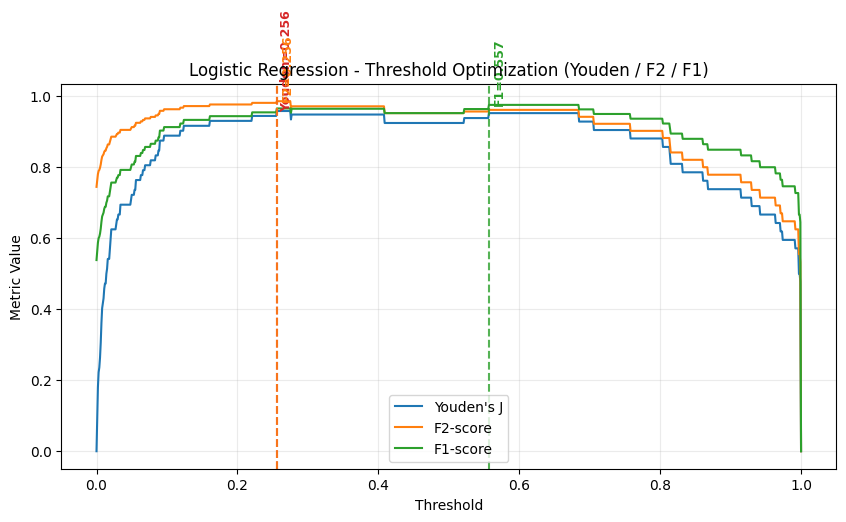


Final Confusion Matrix (Logistic Regression, thr=0.256):
[[69  3]
 [ 0 42]]

Final Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.958     0.979        72
           1      0.933     1.000     0.966        42

    accuracy                          0.974       114
   macro avg      0.967     0.979     0.972       114
weighted avg      0.975     0.974     0.974       114



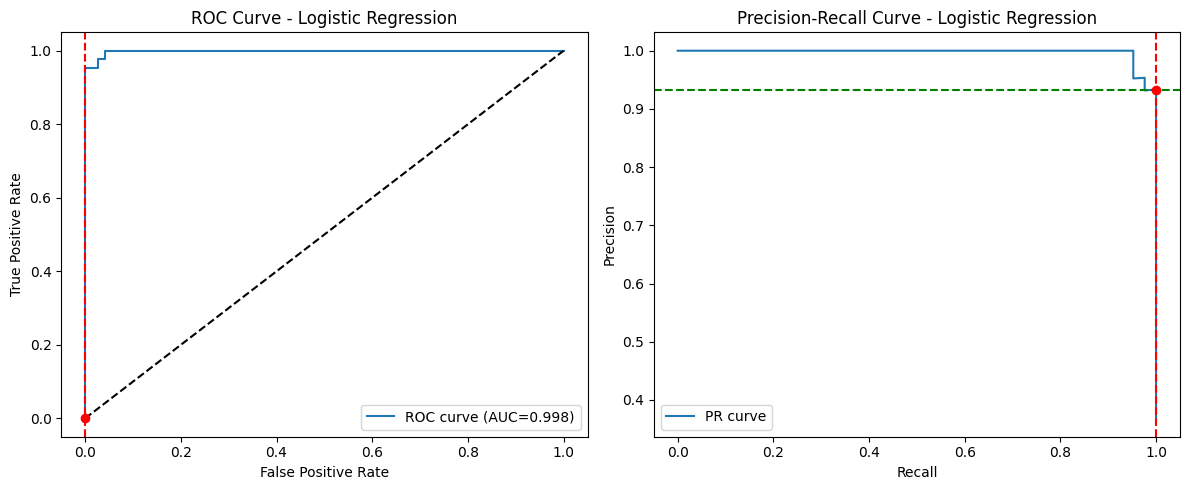


Top 5 Most Important Predictors:

            Feature  Coefficient       Effect
         area_worst     5.171004       Risk ↑
       radius_worst     3.126797       Risk ↑
concave points_mean     2.547958       Risk ↑
        radius_mean    -2.036472 Protective ↓
     perimeter_mean    -2.736285 Protective ↓


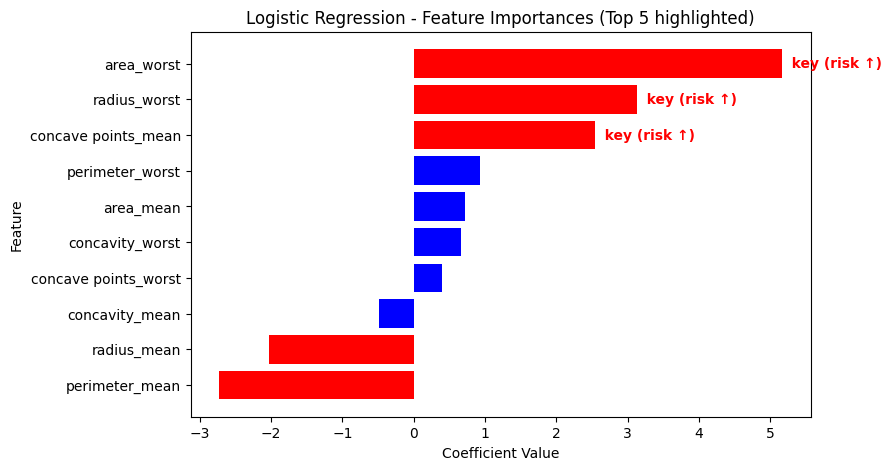


✅ All results and plots saved to 'results/model_outputs/' directory

Best thresholds (Random Forest):
YOUDEN: thr=0.472, prec=1.000, rec=0.929, youden=0.929
F1: thr=0.472, prec=1.000, rec=0.929, f1=0.963
F2: thr=0.133, prec=0.857, rec=1.000, f2=0.968


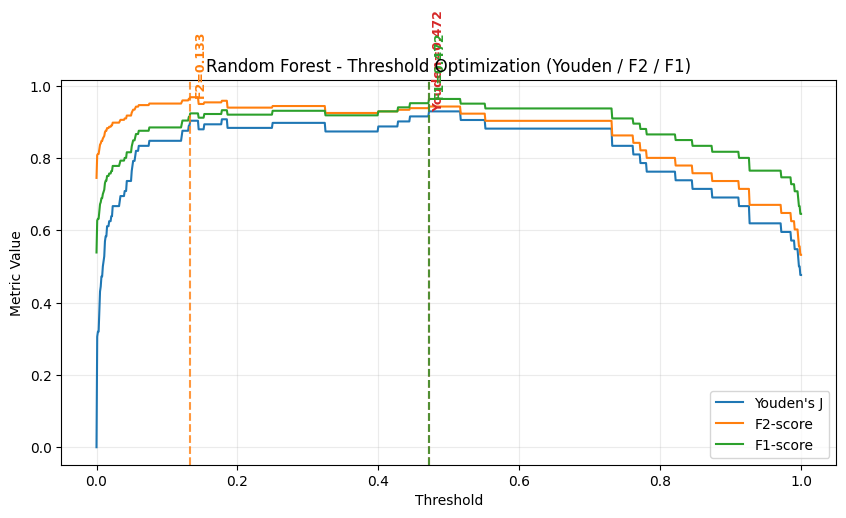


Final Confusion Matrix (Random Forest, thr=0.472):
[[72  0]
 [ 3 39]]

Final Classification Report:
              precision    recall  f1-score   support

           0      0.960     1.000     0.980        72
           1      1.000     0.929     0.963        42

    accuracy                          0.974       114
   macro avg      0.980     0.964     0.971       114
weighted avg      0.975     0.974     0.973       114



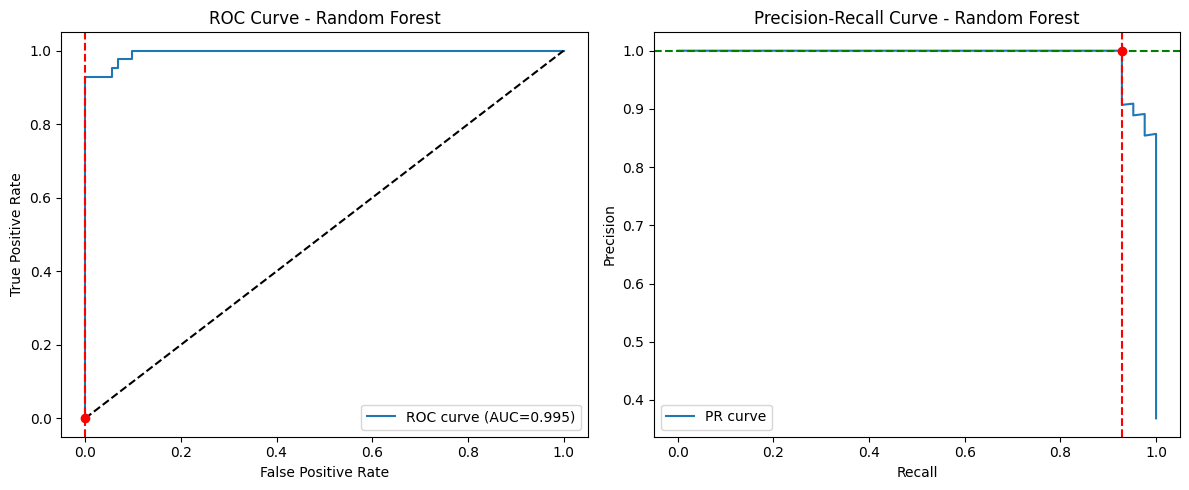

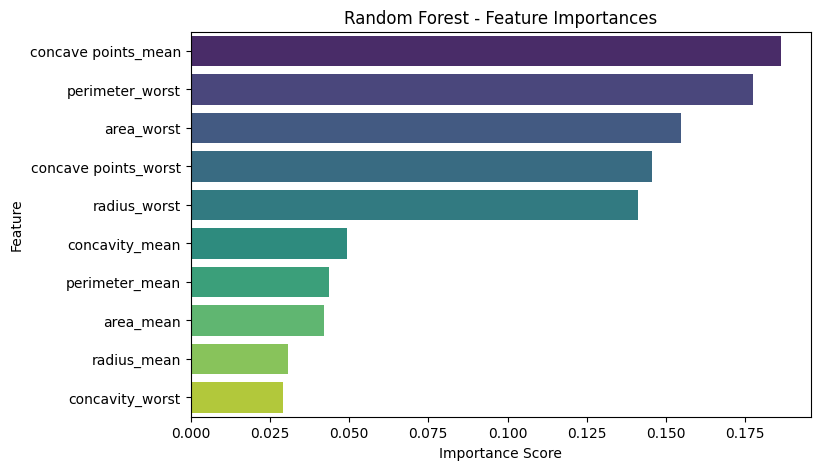


Top 5 Most Important Features:
concave points_mean     0.186286
perimeter_worst         0.177556
area_worst              0.154619
concave points_worst    0.145609
radius_worst            0.141053

✅ All results and plots saved to 'results/model_outputs/' directory

Best thresholds (XGBoost, 5-fold CV):
YOUDEN: thr=0.620, prec=0.943, rec=0.925, youden=0.891
F1: thr=0.620, prec=0.943, rec=0.925, f1=0.933
F2: thr=0.160, prec=0.841, rec=0.972, f2=0.941


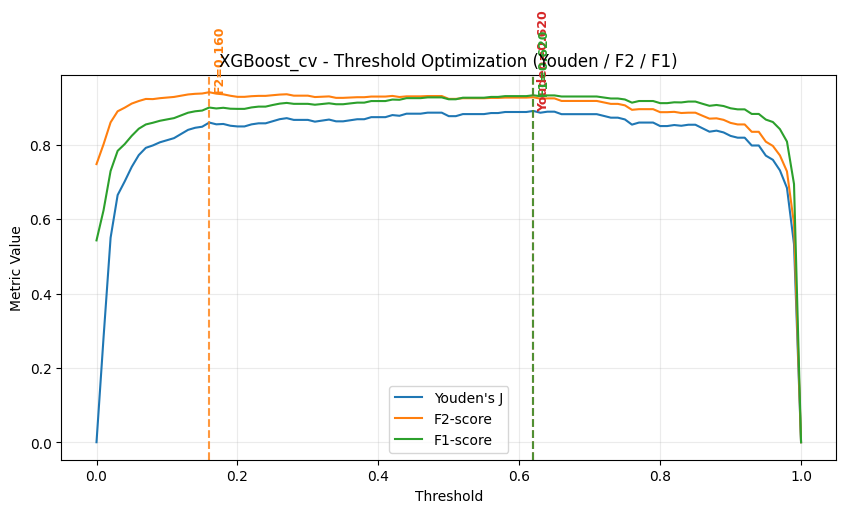


Final Confusion Matrix (XGBoost, thr=0.620):
[[345  12]
 [ 16 196]]

Final Classification Report:
              precision    recall  f1-score   support

           0      0.956     0.966     0.961       357
           1      0.942     0.925     0.933       212

    accuracy                          0.951       569
   macro avg      0.949     0.945     0.947       569
weighted avg      0.951     0.951     0.951       569



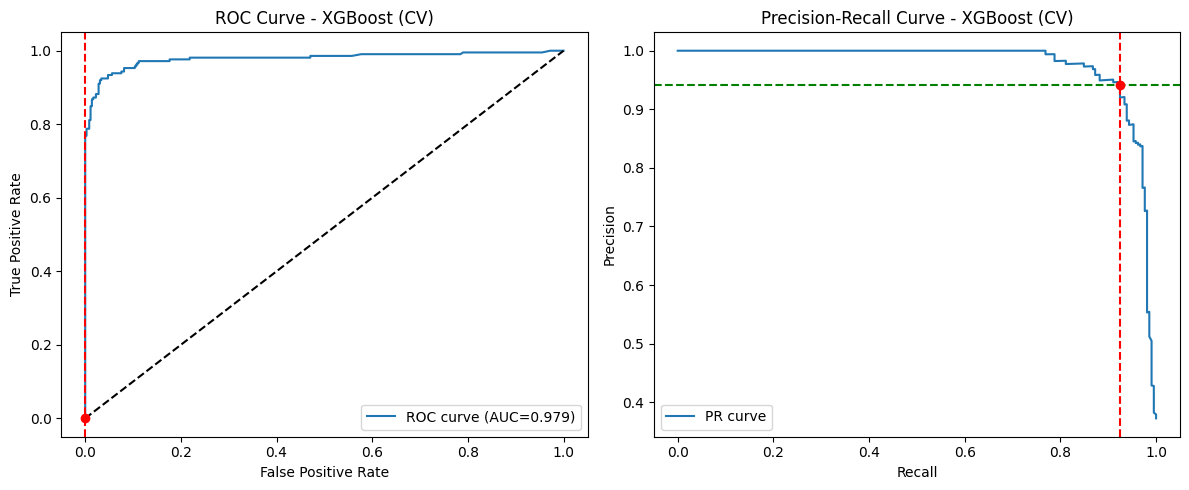

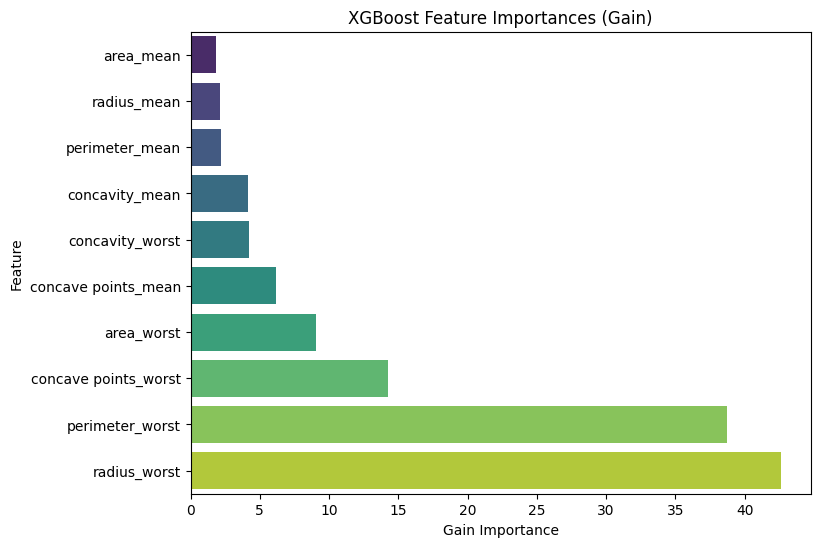


Top 5 Most Important Features (XGB):
                      importance
concave points_mean     6.180921
area_worst              9.059134
concave points_worst   14.272008
perimeter_worst        38.702652
radius_worst           42.623367

✅ All CV results and plots saved to 'results/model_outputs_cv/' directory


In [ ]:
# 5. Run Through Workflows
# -----------------------------
for name, model in best_models.items():
    if "XGB" in name:
        run_model_workflow_cv(model, name, X, y, n_splits=5, step=0.01, feature_names=X.columns)
    else:
        run_model_workflow(model, name, X_train, y_train, X_test, y_test, feature_names=X.columns)

Documentation

In [ ]:
def create_comprehensive_model_results(best_models, lr_grid, rf_grid, xgb_grid, X_train, y_train, X_test, y_test, save_dir="results/tables"):
    """
    Create comprehensive model results tables with hyperparameter tuning info and clinical preferences
    """
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)

    # Initialize results list
    model_results = []

    # Process each model
    for name, model in best_models.items():
        print(f"\nEvaluating {name}...")

        # Get the corresponding grid search object
        if "Logistic" in name:
            grid_obj = lr_grid
        elif "Forest" in name:
            grid_obj = rf_grid
        elif "XGB" in name:
            grid_obj = xgb_grid

        # Make predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        specificity = recall_score(y_test, y_pred, pos_label=0)

        # Get threshold analysis using your evaluate_thresholds_all function
        df_thresh = evaluate_thresholds_all(model, X_test, y_test)
        bests = {
            "youden": best_threshold_by(df_thresh, "youden"),
            "f1": best_threshold_by(df_thresh, "f1"),
            "f2": best_threshold_by(df_thresh, "f2")
        }

        # Collect comprehensive results
        result_row = {
            "Model": name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "F1_Score": f1,
            "ROC_AUC": roc_auc,
            "CV_ROC_AUC": grid_obj.best_score_,
            "Best_Youden_Threshold": bests["youden"].threshold,
            "Best_F1_Threshold": bests["f1"].threshold,
            "Best_F2_Threshold": bests["f2"].threshold,
            "Youden_Score": bests["youden"].youden,
            "Max_F1_Score": bests["f1"].f1,
            "Max_F2_Score": bests["f2"].f2,
            "Hyperparameter_Search_Candidates": len(grid_obj.cv_results_['params']),
            "Best_Params": str(grid_obj.best_params_),
            "Mean_Fit_Time": np.mean(grid_obj.cv_results_['mean_fit_time']),
            "Mean_Score_Time": np.mean(grid_obj.cv_results_['mean_score_time'])
        }

        model_results.append(result_row)

    # Create comprehensive results DataFrame
    df_results = pd.DataFrame(model_results)

    # Round numeric columns for better display
    numeric_cols = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1_Score', 'ROC_AUC', 'CV_ROC_AUC',
                   'Best_Youden_Threshold', 'Best_F1_Threshold', 'Best_F2_Threshold',
                   'Youden_Score', 'Max_F1_Score', 'Max_F2_Score', 'Mean_Fit_Time', 'Mean_Score_Time']
    df_results[numeric_cols] = df_results[numeric_cols].round(4)

    # Clinical preference analysis
    df_results_highlight = df_results.copy()

    # Mark clinical preferences
    best_recall_idx = df_results_highlight['Recall'].idxmax()
    best_precision_idx = df_results_highlight['Precision'].idxmax()
    best_roc_auc_idx = df_results_highlight['ROC_AUC'].idxmax()
    best_f1_idx = df_results_highlight['F1_Score'].idxmax()

    # Add clinical preference columns
    df_results_highlight['Clinical_Best_Recall'] = ""
    df_results_highlight['Clinical_Best_Precision'] = ""
    df_results_highlight['Clinical_Best_ROC_AUC'] = ""
    df_results_highlight['Clinical_Best_F1'] = ""

    df_results_highlight.loc[best_recall_idx, 'Clinical_Best_Recall'] = "✅ Best Sensitivity"
    df_results_highlight.loc[best_precision_idx, 'Clinical_Best_Precision'] = "✅ Best Precision"
    df_results_highlight.loc[best_roc_auc_idx, 'Clinical_Best_ROC_AUC'] = "✅ Best ROC-AUC"
    df_results_highlight.loc[best_f1_idx, 'Clinical_Best_F1'] = "✅ Best F1-Score"

    # Overall clinical recommendation (highest recall for medical screening)
    df_results_highlight['Clinical_Recommendation'] = ""
    df_results_highlight.loc[best_recall_idx, 'Clinical_Recommendation'] = "🏥 RECOMMENDED (Best Recall)"

    # Save comprehensive results
    df_results.to_csv(f"{save_dir}/comprehensive_model_results.csv", index=False)
    df_results_highlight.to_csv(f"{save_dir}/model_results_with_clinical_preference.csv", index=False)

    # Create summary tables

    # 1. Performance Summary (key metrics only)
    performance_summary = df_results[['Model', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'F1_Score', 'ROC_AUC']].copy()
    performance_summary.to_csv(f"{save_dir}/model_performance_summary.csv", index=False)

    # 2. Threshold Analysis Summary
    threshold_summary = df_results[['Model', 'Best_Youden_Threshold', 'Best_F1_Threshold', 'Best_F2_Threshold',
                                   'Youden_Score', 'Max_F1_Score', 'Max_F2_Score']].copy()
    threshold_summary.to_csv(f"{save_dir}/threshold_analysis_summary.csv", index=False)

    # 3. Hyperparameter Tuning Summary
    hyperparameter_summary = df_results[['Model', 'CV_ROC_AUC', 'Best_Params', 'Hyperparameter_Search_Candidates',
                                        'Mean_Fit_Time', 'Mean_Score_Time']].copy()
    hyperparameter_summary.to_csv(f"{save_dir}/hyperparameter_tuning_detailed.csv", index=False)

    # 4. Clinical Decision Support Table
    clinical_summary = df_results_highlight[['Model', 'Recall', 'Precision', 'Specificity', 'F1_Score',
                                           'Clinical_Best_Recall', 'Clinical_Best_Precision',
                                           'Clinical_Best_ROC_AUC', 'Clinical_Best_F1',
                                           'Clinical_Recommendation']].copy()
    clinical_summary.to_csv(f"{save_dir}/clinical_decision_support.csv", index=False)

    # Display results (console output)
    print("\n" + "="*80)
    print("COMPREHENSIVE MODEL RESULTS SUMMARY")
    print("="*80)

    print("\n📊 PERFORMANCE SUMMARY:")
    print(performance_summary.to_string(index=False))

    print(f"\n🎯 CLINICAL RECOMMENDATIONS:")
    print(f"• Best for Screening (Recall): {df_results.loc[best_recall_idx, 'Model']} ({df_results.loc[best_recall_idx, 'Recall']:.3f})")
    print(f"• Best for Precision: {df_results.loc[best_precision_idx, 'Model']} ({df_results.loc[best_precision_idx, 'Precision']:.3f})")
    print(f"• Best Overall (ROC-AUC): {df_results.loc[best_roc_auc_idx, 'Model']} ({df_results.loc[best_roc_auc_idx, 'ROC_AUC']:.3f})")

    print(f"\n⚙️ HYPERPARAMETER TUNING SUMMARY:")
    for idx, row in df_results.iterrows():
        print(f"• {row['Model']}: {row['Hyperparameter_Search_Candidates']} candidates, "
              f"CV ROC-AUC: {row['CV_ROC_AUC']:.3f}")

    print("\n" + "="*80)
    print(f"✅ All detailed results saved to '{save_dir}/' directory")
    print("="*80)

    # Create highlighting function for display
    def highlight_clinical(s):
        colors = []
        for v in s:
            if "✅" in str(v) or "🏥" in str(v):
                colors.append('background-color: gold')
            else:
                colors.append('')
        return colors

    # Return styled dataframe for notebook display
    styled_results = df_results_highlight.style.apply(highlight_clinical,
                                                     subset=['Clinical_Best_Recall', 'Clinical_Best_Precision',
                                                            'Clinical_Best_ROC_AUC', 'Clinical_Best_F1',
                                                            'Clinical_Recommendation'])

    return df_results, df_results_highlight, styled_results

# Function to create additional analysis tables
def create_model_comparison_charts(df_results, save_dir="results/tables"):
    """
    Create additional comparison tables and rankings
    """
    os.makedirs(save_dir, exist_ok=True)

    # Ranking by different metrics
    metrics_to_rank = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1_Score', 'ROC_AUC']

    rankings = {}
    for metric in metrics_to_rank:
        rankings[f'{metric}_Rank'] = df_results['Model'].iloc[df_results[metric].argsort()[::-1]].values

    ranking_df = pd.DataFrame(rankings)
    ranking_df.index = ['1st Place', '2nd Place', '3rd Place']
    ranking_df.to_csv(f"{save_dir}/model_rankings_by_metric.csv")

    print("\n📈 MODEL RANKINGS BY METRIC:")
    print(ranking_df.to_string())

    return ranking_df

# Usage function
def run_complete_model_analysis():
    """
    Run the complete model analysis using your existing variables
    """
    # Create comprehensive results
    df_results, df_results_highlight, styled_results = create_comprehensive_model_results(
        best_models, lr_grid, rf_grid, xgb_grid, X_train, y_train, X_test, y_test
    )

    # Create additional analysis
    ranking_df = create_model_comparison_charts(df_results)

    print(f"\n🎉 Complete model analysis finished!")
    print(f"📁 Check 'results/tables/' for all saved files")

    return df_results, df_results_highlight, styled_results, ranking_df

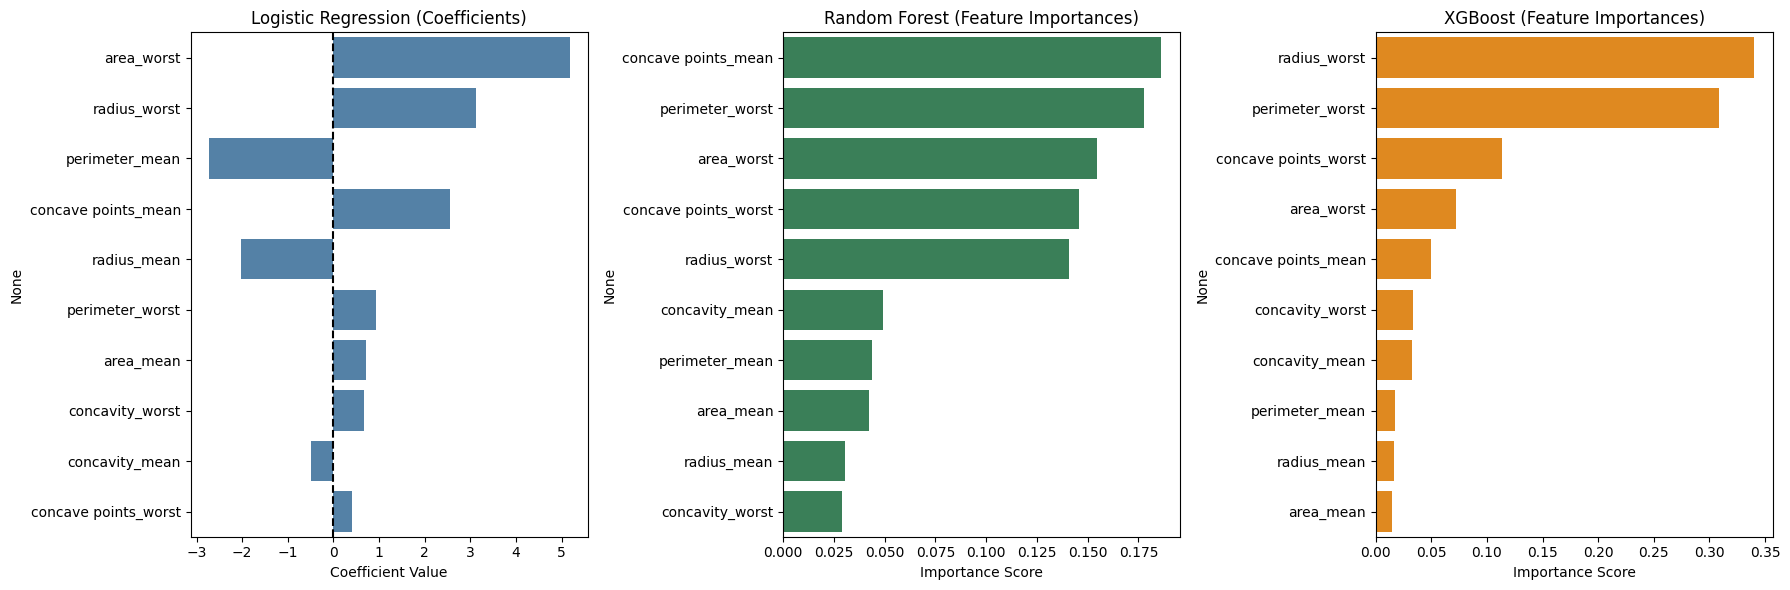


Top 5 Features per Model:

   Logistic Regression         Random Forest               XGBoost
0           area_worst   concave points_mean          radius_worst
1         radius_worst       perimeter_worst       perimeter_worst
2       perimeter_mean            area_worst  concave points_worst
3  concave points_mean  concave points_worst            area_worst
4          radius_mean          radius_worst   concave points_mean

Evaluating Logistic Regression...

Evaluating Random Forest...

Evaluating XGBoost...

COMPREHENSIVE MODEL RESULTS SUMMARY

📊 PERFORMANCE SUMMARY:
              Model  Accuracy  Precision  Recall  Specificity  F1_Score  ROC_AUC
Logistic Regression    0.9649     0.9524  0.9524       0.9722    0.9524   0.9983
      Random Forest    0.9737     1.0000  0.9286       1.0000    0.9630   0.9947
            XGBoost    0.9912     1.0000  0.9762       1.0000    0.9880   0.9977

🎯 CLINICAL RECOMMENDATIONS:
• Best for Screening (Recall): XGBoost (0.976)
• Best for Precision: 

In [ ]:
# Create directories
os.makedirs("results/tables", exist_ok=True)
os.makedirs("results/plots", exist_ok=True)

# -----------------------------
# Feature Importances per Model (Using Tuned Models)
# -----------------------------

# Logistic Regression Importances (coefficients) - from tuned model
lr_clf = best_lr.named_steps["clf"]
lr_importances = pd.Series(
    lr_clf.coef_[0], index=X_train.columns
).sort_values(key=abs, ascending=False)

# Random Forest Importances - from tuned model
rf_clf = best_rf.named_steps["clf"]
rf_importances = pd.Series(
    rf_clf.feature_importances_, index=X_train.columns
).sort_values(ascending=False)

# XGBoost Importances - from tuned model
xgb_clf = best_xgb.named_steps["clf"]
xgb_importances = pd.Series(
    xgb_clf.feature_importances_, index=X_train.columns
).sort_values(ascending=False)

# Save individual feature importances
lr_importances.to_csv("results/tables/logistic_regression_importances.csv", header=['coefficient'])
rf_importances.to_csv("results/tables/random_forest_importances.csv", header=['importance'])
xgb_importances.to_csv("results/tables/xgboost_importances.csv", header=['importance'])

# -----------------------------
# Plot 3 separate bar charts
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18,6))

# Logistic Regression
sns.barplot(x=lr_importances.values, y=lr_importances.index,
            ax=axes[0], color="steelblue")
axes[0].axvline(0, color="black", linestyle="--")  # line at 0
axes[0].set_title("Logistic Regression (Coefficients)")
axes[0].set_xlabel("Coefficient Value")

# Random Forest
sns.barplot(x=rf_importances.values, y=rf_importances.index,
            ax=axes[1], color="seagreen")
axes[1].set_title("Random Forest (Feature Importances)")
axes[1].set_xlabel("Importance Score")

# XGBoost
sns.barplot(x=xgb_importances.values, y=xgb_importances.index,
            ax=axes[2], color="darkorange")
axes[2].set_title("XGBoost (Feature Importances)")
axes[2].set_xlabel("Importance Score")

plt.tight_layout()
# Save the plot
plt.savefig("results/plots/feature_importances_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# Summary Table: Top 5 Features per Model
# -----------------------------
top_features = pd.DataFrame({
    "Logistic Regression": lr_importances.head(5).index.tolist(),
    "Random Forest": rf_importances.head(5).index.tolist(),
    "XGBoost": xgb_importances.head(5).index.tolist()
})

# Save top features table
top_features.to_csv("results/tables/top_5_features_per_model.csv", index=False)

print("\nTop 5 Features per Model:\n")
print(top_features)

# -----------------------------
# Model Results Summary # Run the complete model analysis
df_results, df_results_highlight, styled_results, ranking_df = run_complete_model_analysis()

# Feature selections (with threshold > 0.05)
lr_selected  = set(lr_importances[lr_importances.abs() > 0.05].index)
rf_selected  = set(rf_importances[rf_importances > 0.05].index)
xgb_selected = set(xgb_importances[xgb_importances > 0.05].index)

# Save selected features
pd.DataFrame({"Logistic Regression Selected": list(lr_selected)}).to_csv("results/tables/lr_selected_features.csv", index=False)
pd.DataFrame({"Random Forest Selected": list(rf_selected)}).to_csv("results/tables/rf_selected_features.csv", index=False)
pd.DataFrame({"XGBoost Selected": list(xgb_selected)}).to_csv("results/tables/xgb_selected_features.csv", index=False)

# Common features
common_features = lr_selected & rf_selected & xgb_selected
pd.DataFrame({"Common Features": list(common_features)}).to_csv("results/tables/common_features_all_models.csv", index=False)

# Save threshold metrics if they exist
if 'lr_thresh_df' in locals():
    lr_thresh_df.to_csv("results/tables/threshold_metrics_lr.csv", index=False)
if 'rf_thresh_df' in locals():
    rf_thresh_df.to_csv("results/tables/threshold_metrics_rf.csv", index=False)
if 'xgb_thresh_df' in locals():
    xgb_thresh_df.to_csv("results/tables/threshold_metrics_xgb.csv", index=False)

print("\n✅ All feature importance analysis and tables saved to 'results/' directories")

**Explainability Analysis using SHAP**

Starting Random Forest SHAP Analysis...

RANDOM FOREST SHAP ANALYSIS - Random Forest
Data shapes - Train: (455, 10), Test: (114, 10)
Creating TreeExplainer...
Computing SHAP values for 114 test samples...
3D SHAP values detected (shape: (114, 10, 2)) - using positive class
Final SHAP values shape: (114, 10)
Creating SHAP feature importance plot...


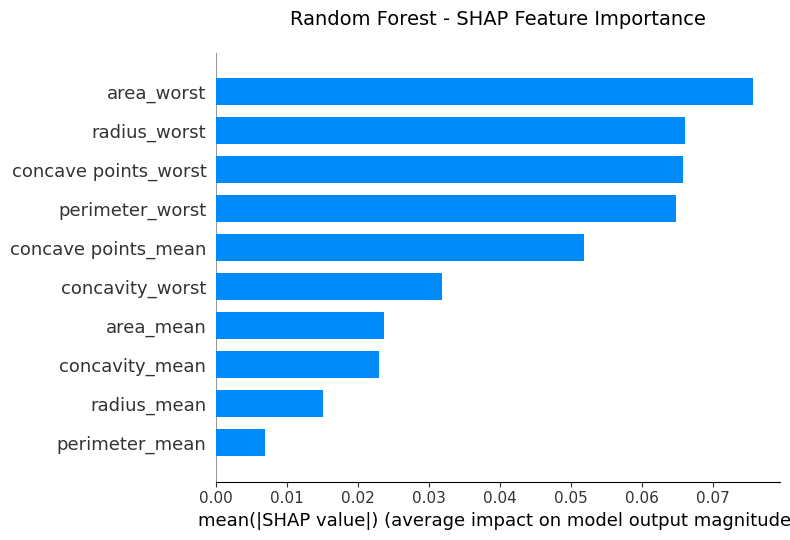

Creating SHAP summary plot...


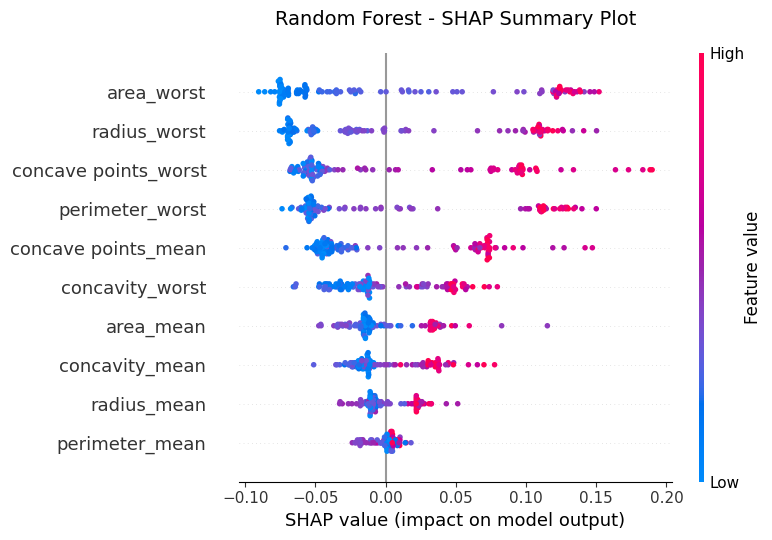

Computing global SHAP importance...

Top 10 Most Important Features (Random Forest - SHAP):
 1. area_worst                     0.0756
 2. radius_worst                   0.0661
 3. concave points_worst           0.0658
 4. perimeter_worst                0.0648
 5. concave points_mean            0.0519
 6. concavity_worst                0.0318
 7. area_mean                      0.0236
 8. concavity_mean                 0.0230
 9. radius_mean                    0.0150
10. perimeter_mean                 0.0069

Creating individual prediction explanations...
Creating SHAP explanation 1...


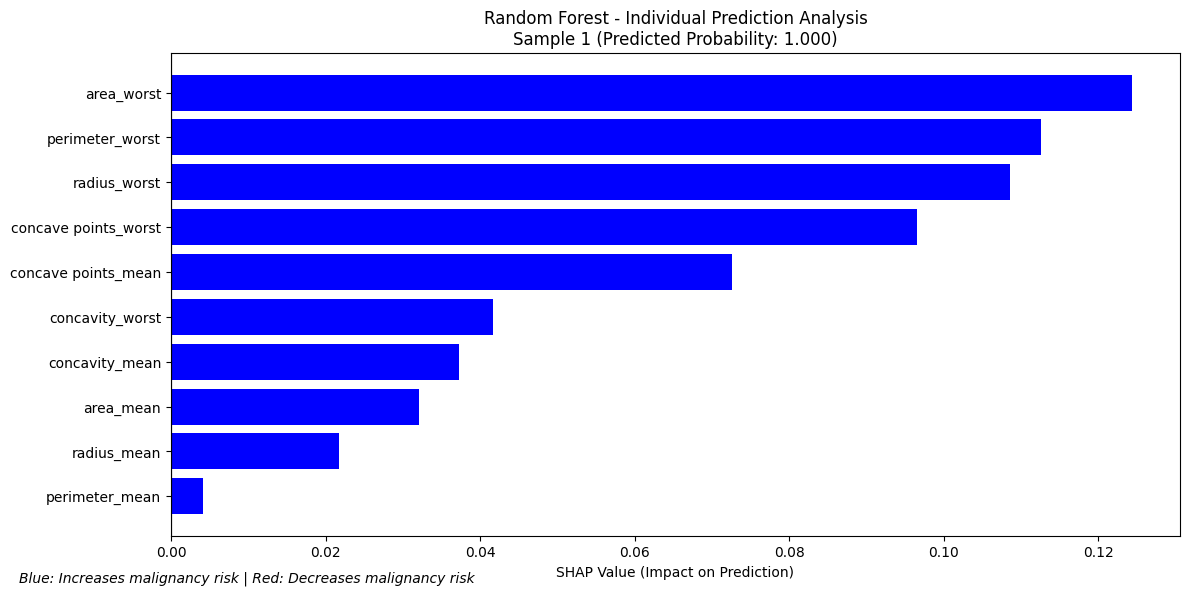

Creating SHAP explanation 2...


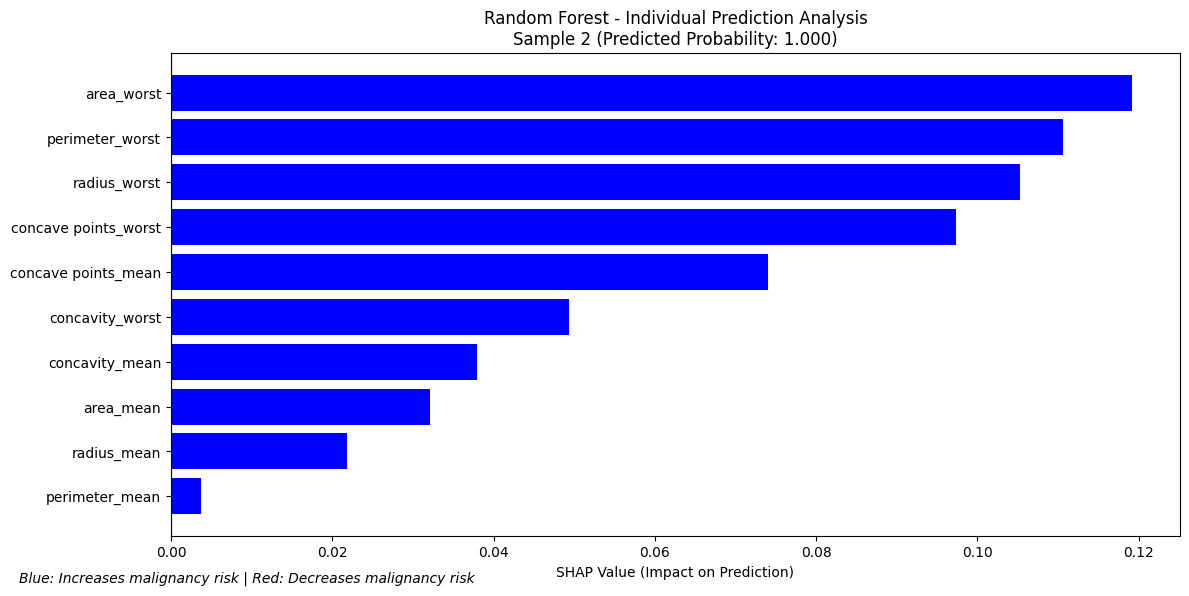

Creating alternative importance visualization...


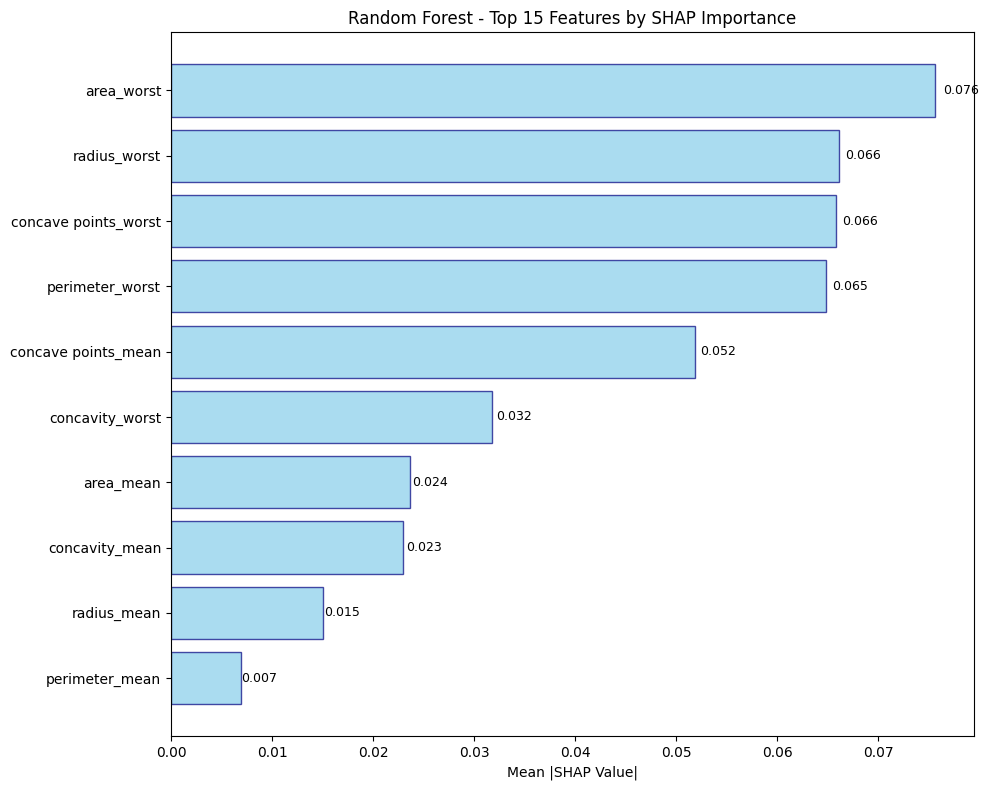

Creating feature interaction analysis...


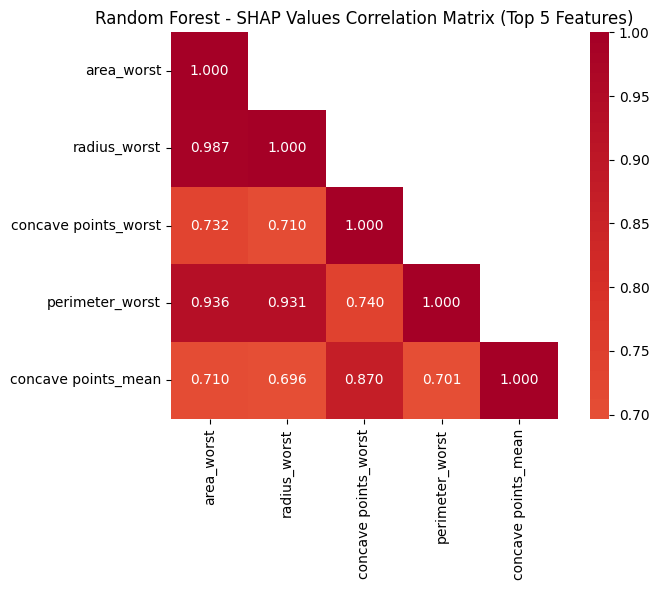


✅ Random Forest SHAP analysis completed successfully!
📁 All SHAP results saved to: results/model_outputs/shap_analysis/

🎉 Random Forest SHAP analysis completed!
📊 Analyzed 114 test samples
📈 Generated 7 visualizations


In [ ]:
"""Random Forest SHAP Analysis - Integration with Existing Workflow"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os

def random_forest_shap_analysis(best_models, X_train, X_test, y_test, save_dir="results/model_outputs"):
    """
    Dedicated SHAP analysis for Random Forest model that integrates with your existing workflow
    """

    # Check if Random Forest exists in best_models
    rf_model = None
    rf_name = None

    for name, model in best_models.items():
        if "Forest" in name:
            rf_model = model
            rf_name = name
            break

    if rf_model is None:
        print("❌ No Random Forest model found in best_models")
        return None

    print(f"\n{'='*70}")
    print(f"RANDOM FOREST SHAP ANALYSIS - {rf_name}")
    print(f"{'='*70}")

    # Create SHAP-specific directory
    shap_dir = os.path.join(save_dir, "shap_analysis")
    os.makedirs(shap_dir, exist_ok=True)

    try:
        # Extract classifier from pipeline if needed
        if hasattr(rf_model, 'named_steps'):
            rf_clf = rf_model.named_steps['clf']
        else:
            rf_clf = rf_model

        # Get feature names
        feature_names = X_train.columns.tolist()

        # Transform data - simplified approach
        if hasattr(rf_model, 'named_steps') and len(rf_model.steps) > 0:
            # Pipeline with steps
            rf_clf = rf_model.named_steps['clf']
            # Check if there are preprocessing steps
            if len(rf_model.steps) > 1:
                # Has preprocessing - transform data
                X_train_transformed = rf_model[:-1].transform(X_train)
                X_test_transformed = rf_model[:-1].transform(X_test)
            else:
                # Only classifier in pipeline
                X_train_transformed = X_train.values
                X_test_transformed = X_test.values
        else:
            # Single model, no pipeline
            rf_clf = rf_model
            X_train_transformed = X_train.values
            X_test_transformed = X_test.values

        # Ensure proper array format
        X_train_transformed = np.asarray(X_train_transformed, dtype=np.float32)
        X_test_transformed = np.asarray(X_test_transformed, dtype=np.float32)

        print(f"Data shapes - Train: {X_train_transformed.shape}, Test: {X_test_transformed.shape}")

        # Create background sample for TreeExplainer
        background_size = min(100, len(X_train_transformed))
        rng = np.random.RandomState(42)
        background_indices = rng.choice(len(X_train_transformed), background_size, replace=False)
        background_data = X_train_transformed[background_indices]

        # Create SHAP explainer
        print("Creating TreeExplainer...")
        explainer = shap.TreeExplainer(rf_clf, background_data)

        # Calculate SHAP values for subset (for performance)
        test_size = min(200, len(X_test_transformed))
        test_subset = X_test_transformed[:test_size]

        print(f"Computing SHAP values for {test_size} test samples...")
        shap_values = explainer.shap_values(test_subset)

        # Handle binary classification output
        if isinstance(shap_values, list):
            print(f"Binary classification detected - using positive class SHAP values")
            shap_values = shap_values[1]  # Use positive class (malignant)
        elif len(shap_values.shape) == 3:
            print(f"3D SHAP values detected (shape: {shap_values.shape}) - using positive class")
            shap_values = shap_values[:, :, 1]  # Use positive class (malignant)

        print(f"Final SHAP values shape: {shap_values.shape}")

        # Close any existing plots
        plt.close('all')

        # 1. SHAP Feature Importance Plot
        print("Creating SHAP feature importance plot...")
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, test_subset, feature_names=feature_names,
                         plot_type="bar", show=False, max_display=15)
        plt.title(f"{rf_name} - SHAP Feature Importance", fontsize=14, pad=20)
        plt.tight_layout()
        plt.savefig(f"{shap_dir}/{rf_name}_shap_feature_importance.png",
                   dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # 2. SHAP Summary Plot (Beeswarm)
        print("Creating SHAP summary plot...")
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, test_subset, feature_names=feature_names,
                         show=False, max_display=15)
        plt.title(f"{rf_name} - SHAP Summary Plot", fontsize=14, pad=20)
        plt.tight_layout()
        plt.savefig(f"{shap_dir}/{rf_name}_shap_summary_plot.png",
                   dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # 3. Calculate and save global importance
        print("Computing global SHAP importance...")
        mean_shap_importance = np.abs(shap_values).mean(axis=0)

        importance_df = pd.DataFrame({
            'feature': feature_names,
            'mean_shap_importance': mean_shap_importance,
            'std_shap_importance': np.abs(shap_values).std(axis=0)
        }).sort_values('mean_shap_importance', ascending=False)

        # Save importance table
        importance_df.to_csv(f"{shap_dir}/{rf_name}_shap_global_importance.csv", index=False)

        print(f"\nTop 10 Most Important Features ({rf_name} - SHAP):")
        print("=" * 60)
        top_10 = importance_df.head(10)
        for i, (_, row) in enumerate(top_10.iterrows(), 1):
            print(f"{i:2d}. {row['feature']:<30} {row['mean_shap_importance']:.4f}")

        # 4. Individual prediction explanations
        print("\nCreating individual prediction explanations...")

        # Get predictions for test subset
        y_proba_subset = rf_model.predict_proba(X_test.iloc[:test_size])[:, 1]

        # Find 2 most confident malignant predictions
        confident_indices = np.argsort(y_proba_subset)[-2:]

        for i, idx in enumerate(confident_indices):
            print(f"Creating SHAP explanation {i+1}...")

            # Create bar plot of SHAP values
            plt.figure(figsize=(12, 6))

            single_shap = shap_values[idx]
            top_feature_indices = np.argsort(np.abs(single_shap))[-10:]  # Top 10 by magnitude

            colors = ['red' if val < 0 else 'blue' for val in single_shap[top_feature_indices]]

            plt.barh(range(len(top_feature_indices)), single_shap[top_feature_indices], color=colors)
            plt.yticks(range(len(top_feature_indices)), [feature_names[j] for j in top_feature_indices])
            plt.xlabel('SHAP Value (Impact on Prediction)')
            plt.title(f'{rf_name} - Individual Prediction Analysis\n'
                     f'Sample {i+1} (Predicted Probability: {y_proba_subset[idx]:.3f})')
            plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

            # Add legend
            plt.figtext(0.02, 0.02, 'Blue: Increases malignancy risk | Red: Decreases malignancy risk',
                       fontsize=10, style='italic')

            plt.tight_layout()
            plt.savefig(f"{shap_dir}/{rf_name}_shap_explanation_{i+1}.png",
                       dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()

        # 5. Alternative importance visualization
        print("Creating alternative importance visualization...")

        top_15_features = importance_df.head(15)

        plt.figure(figsize=(10, 8))
        bars = plt.barh(range(len(top_15_features)), top_15_features['mean_shap_importance'],
                       color='skyblue', edgecolor='navy', alpha=0.7)

        plt.yticks(range(len(top_15_features)), top_15_features['feature'])
        plt.xlabel('Mean |SHAP Value|')
        plt.title(f'{rf_name} - Top 15 Features by SHAP Importance')
        plt.gca().invert_yaxis()

        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                    f'{width:.3f}', ha='left', va='center', fontsize=9)

        plt.tight_layout()
        plt.savefig(f"{shap_dir}/{rf_name}_shap_importance_horizontal.png",
                   dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # 6. Feature interaction analysis (simplified)
        print("Creating feature interaction analysis...")

        try:
            # Get top 5 features for interaction
            top_5_features = importance_df.head(5)['feature'].tolist()
            top_5_indices = [feature_names.index(f) for f in top_5_features]

            # Create correlation matrix of SHAP values
            top_shap_values = shap_values[:, top_5_indices]
            shap_corr_matrix = np.corrcoef(top_shap_values.T)

            plt.figure(figsize=(8, 6))
            mask = np.triu(np.ones_like(shap_corr_matrix, dtype=bool), k=1)
            sns.heatmap(shap_corr_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                       square=True, fmt='.3f',
                       xticklabels=top_5_features, yticklabels=top_5_features)
            plt.title(f'{rf_name} - SHAP Values Correlation Matrix (Top 5 Features)')
            plt.tight_layout()
            plt.savefig(f"{shap_dir}/{rf_name}_shap_correlation_matrix.png",
                       dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()

            # Save correlation matrix
            corr_df = pd.DataFrame(shap_corr_matrix,
                                  index=top_5_features,
                                  columns=top_5_features)
            corr_df.to_csv(f"{shap_dir}/{rf_name}_shap_correlation_matrix.csv")

        except Exception as e:
            print(f"Could not create interaction analysis: {e}")

        print(f"\n✅ {rf_name} SHAP analysis completed successfully!")
        print(f"📁 All SHAP results saved to: {shap_dir}/")

        # Integration with existing workflow - save summary for comparison
        shap_summary = {
            'model_name': rf_name,
            'top_features': importance_df.head(10)['feature'].tolist(),
            'top_importances': importance_df.head(10)['mean_shap_importance'].tolist(),
            'total_samples_analyzed': test_size,
            'shap_files_created': [
                f"{rf_name}_shap_feature_importance.png",
                f"{rf_name}_shap_summary_plot.png",
                f"{rf_name}_shap_global_importance.csv",
                f"{rf_name}_shap_explanation_1.png",
                f"{rf_name}_shap_explanation_2.png",
                f"{rf_name}_shap_importance_horizontal.png",
                f"{rf_name}_shap_correlation_matrix.png"
            ]
        }

        # Save summary
        import json
        with open(f"{shap_dir}/{rf_name}_shap_summary.json", 'w') as f:
            json.dump(shap_summary, f, indent=2, default=str)

        return {
            'explainer': explainer,
            'shap_values': shap_values,
            'importance_df': importance_df,
            'summary': shap_summary
        }

    except Exception as e:
        print(f"❌ Error in Random Forest SHAP analysis: {e}")
        import traceback
        traceback.print_exc()
        return None

# Run the Random Forest SHAP analysis
print("Starting Random Forest SHAP Analysis...")
rf_shap_results = random_forest_shap_analysis(
    best_models=best_models,
    X_train=X_train,
    X_test=X_test,
    y_test=y_test,
    save_dir="results/model_outputs"
)

if rf_shap_results:
    print(f"\n🎉 Random Forest SHAP analysis completed!")
    print(f"📊 Analyzed {rf_shap_results['summary']['total_samples_analyzed']} test samples")
    print(f"📈 Generated {len(rf_shap_results['summary']['shap_files_created'])} visualizations")
else:
    print("❌ SHAP analysis failed - please check error messages above")

Starting SHAP Explainability Analysis (excluding Random Forest)...
This may take a few minutes...

SHAP Analysis for Logistic Regression


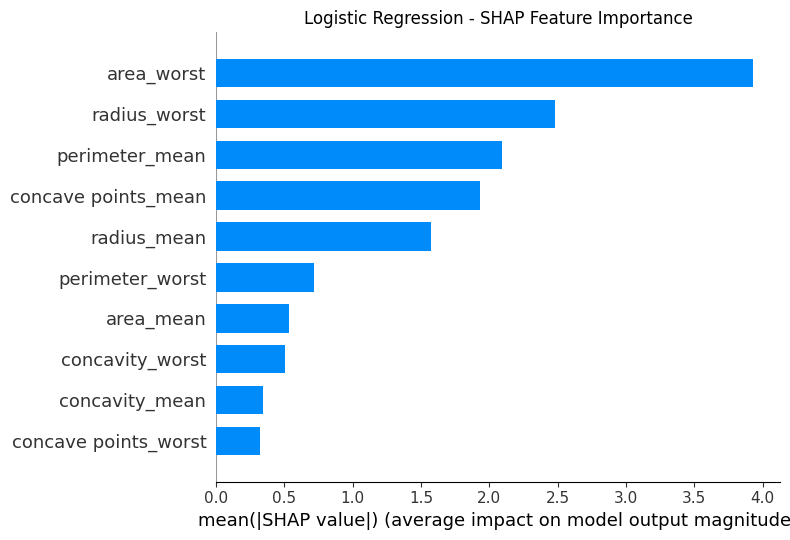

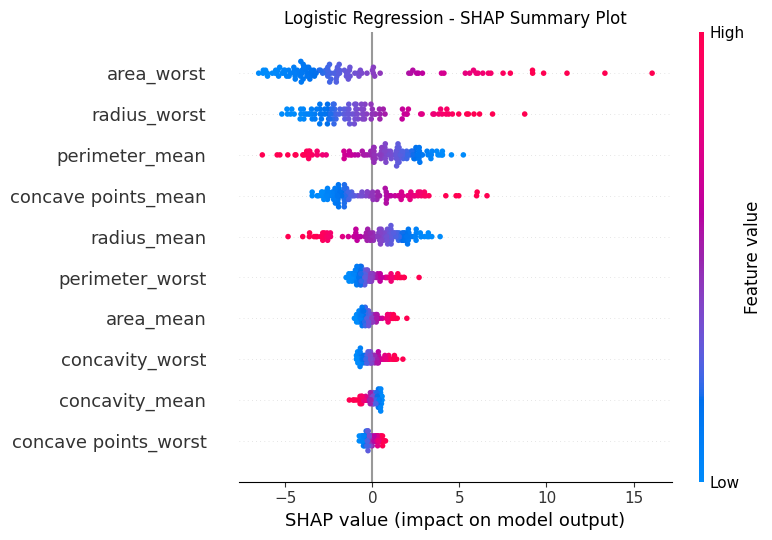

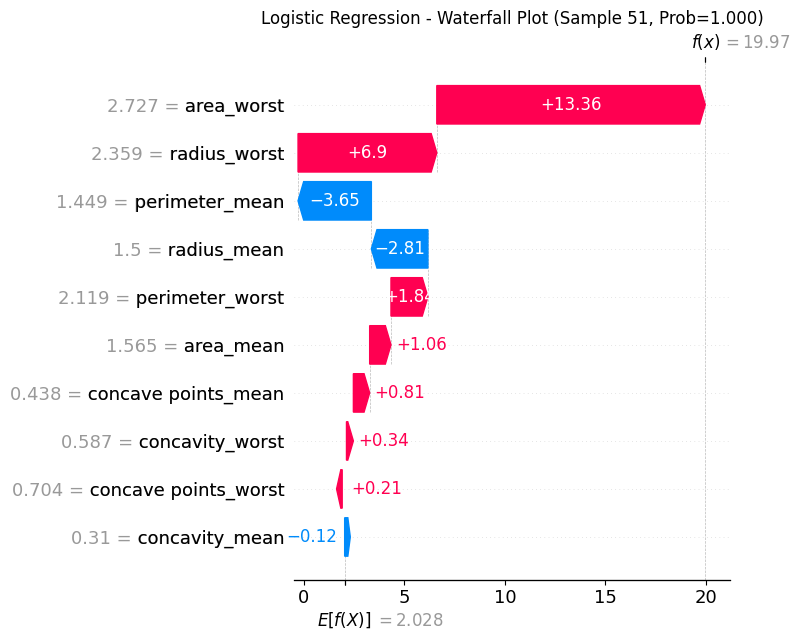

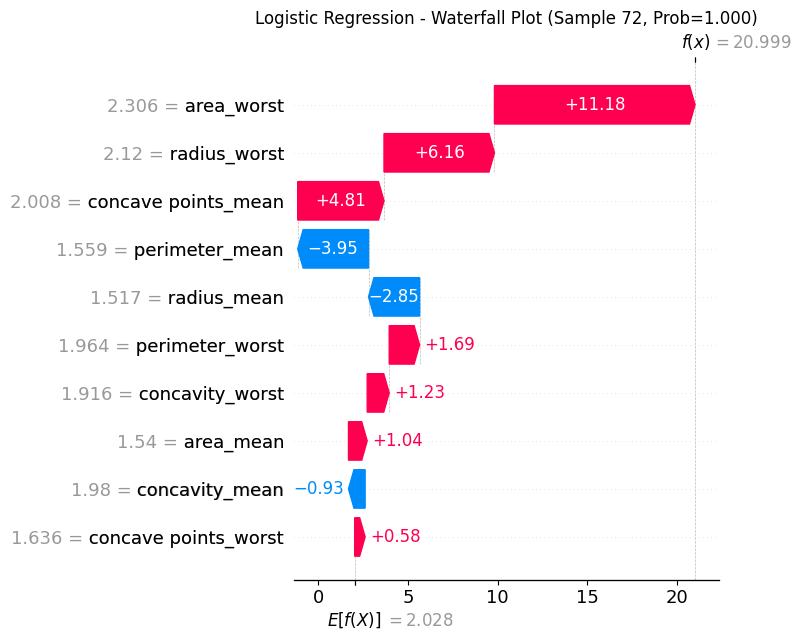

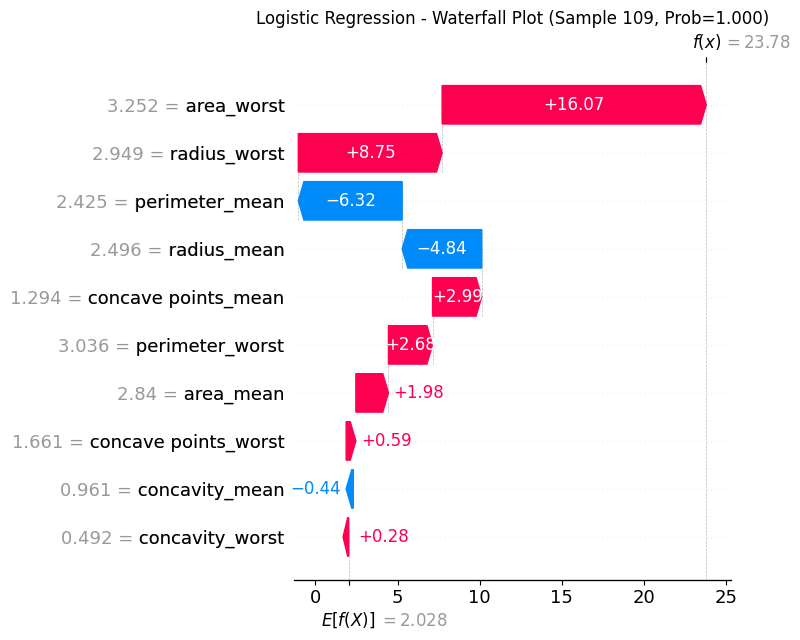

✅ SHAP analysis completed for Logistic Regression
Skipping Random Forest - handled by separate Random Forest SHAP analysis

SHAP Analysis for XGBoost


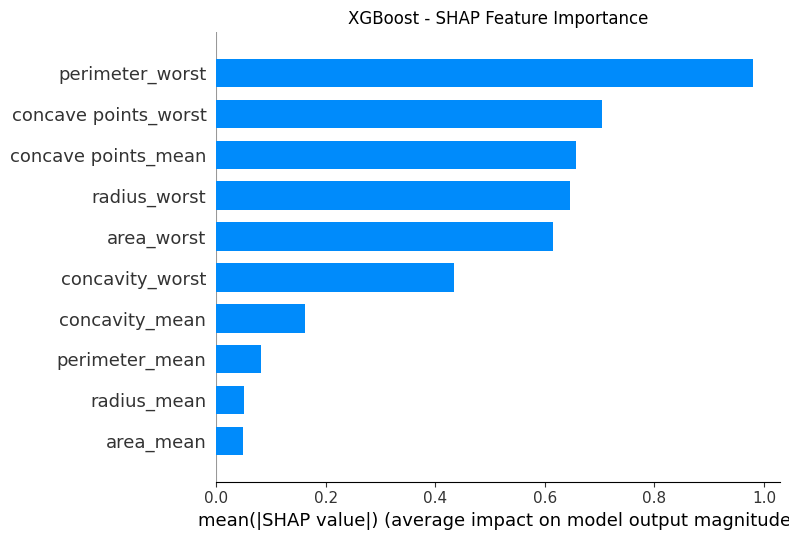

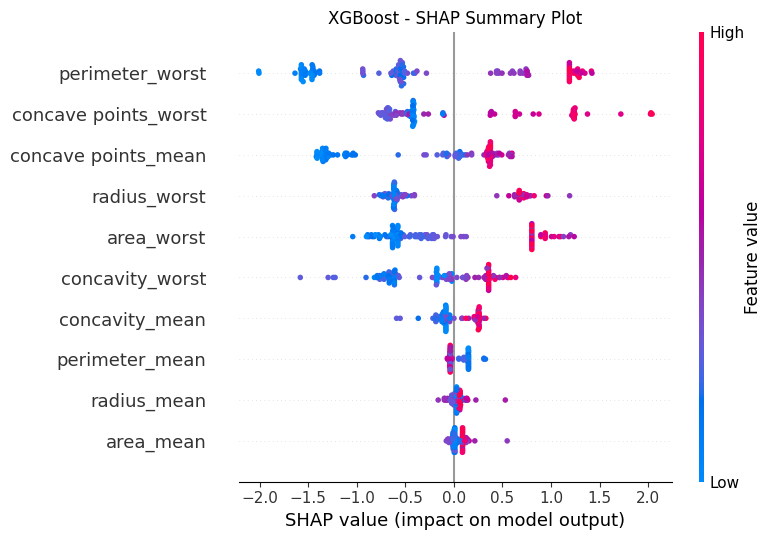

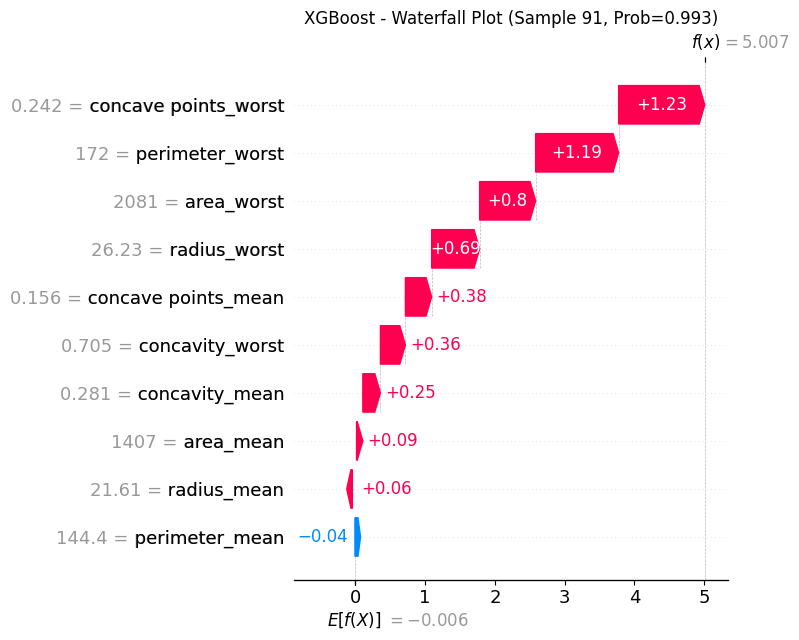

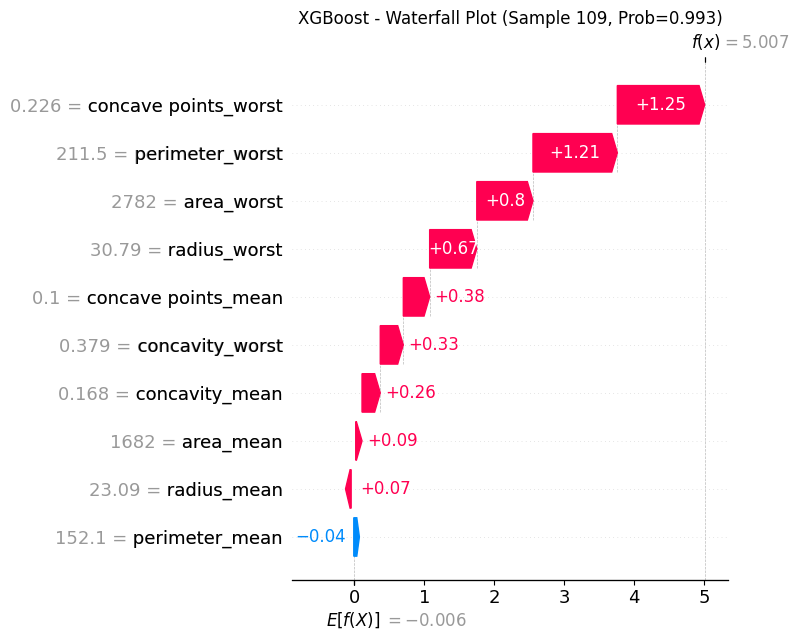

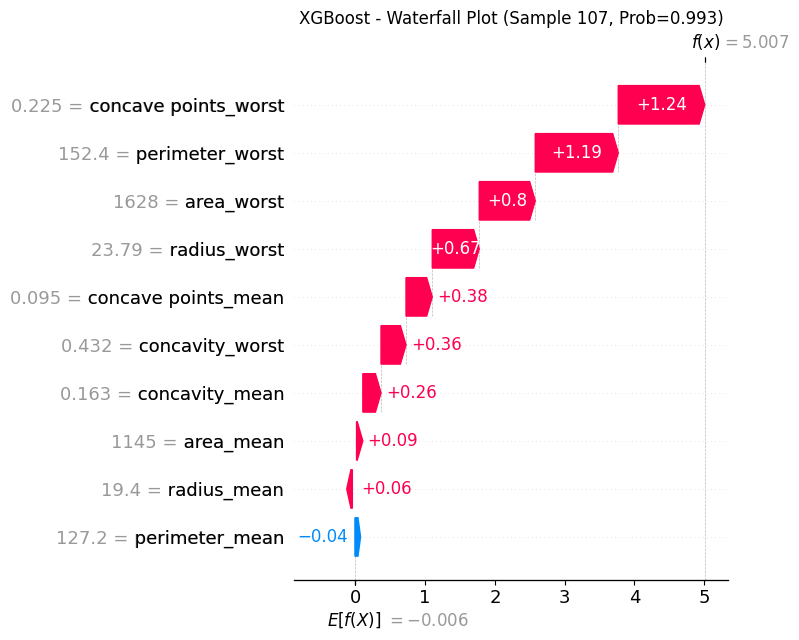

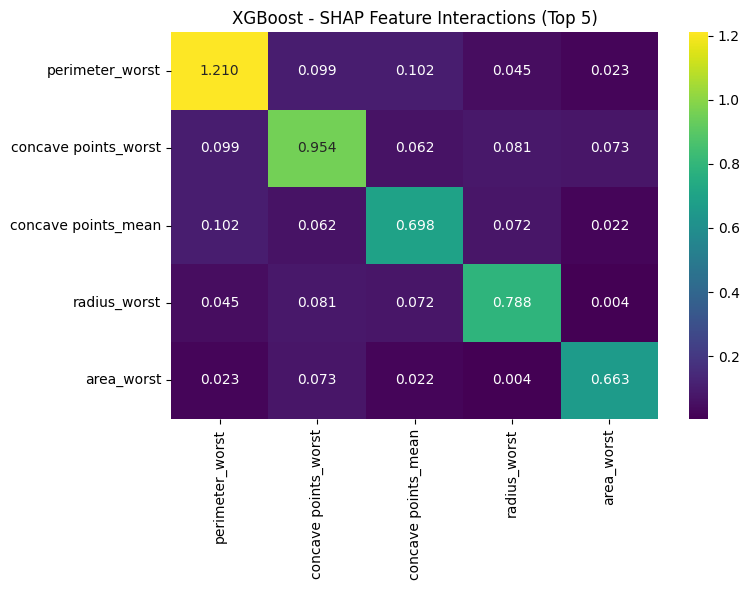

✅ SHAP analysis completed for XGBoost


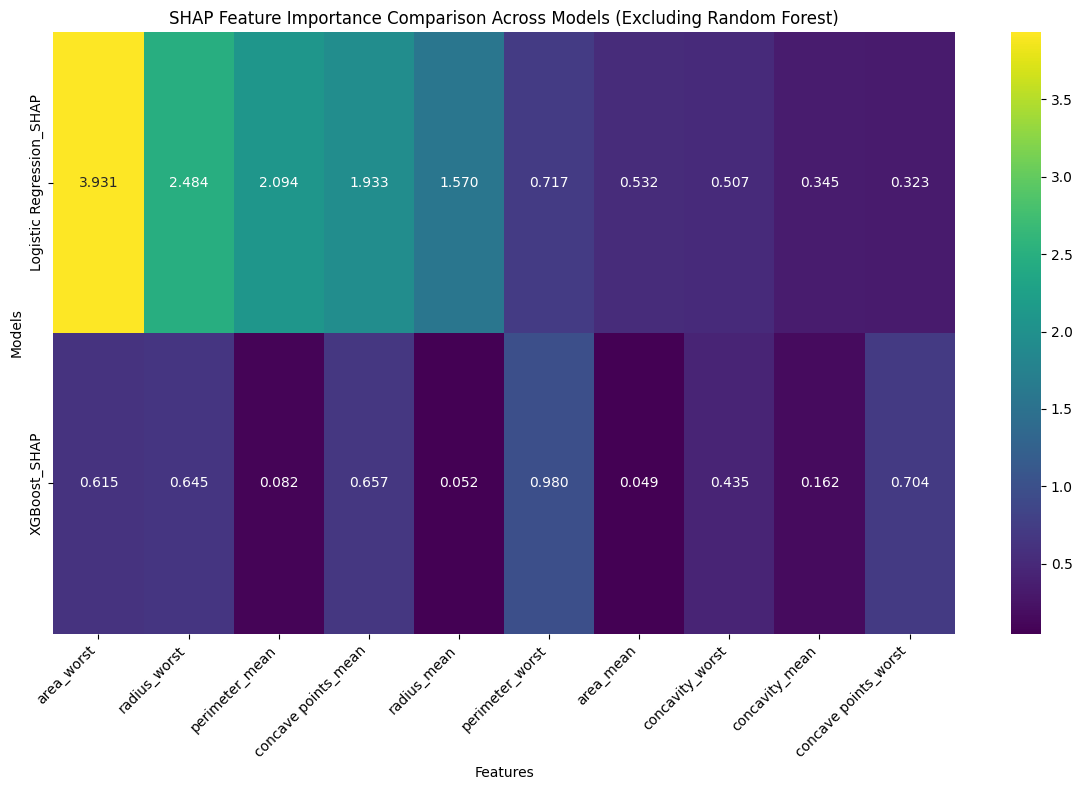

✅ SHAP comparison summary created

SHAP EXPLAINABILITY ANALYSIS SUMMARY
Models analyzed: 2 (Random Forest handled separately)
Plots generated per model: ~4-5
Tables generated per model: 2-3

Generated visualizations:
• Feature importance bar plots
• Detailed summary plots (beeswarm)
• Waterfall plots for individual predictions
• Feature interaction heatmaps (XGBoost only)
• Cross-model SHAP comparison heatmap

✅ All SHAP results saved to 'results/' directories
📝 Note: Random Forest SHAP analysis is handled by separate dedicated script


In [ ]:
"""SHAP Explainability Analysis - Main Models (Excluding Random Forest)"""

# Initialize SHAP explainers for each model
def create_shap_analysis(best_models, X_train, X_test, y_test, feature_names, save_dir="results"):
    """
    Create comprehensive SHAP analysis for all models (excluding Random Forest)
    """
    # Create directories
    os.makedirs(f"{save_dir}/plots", exist_ok=True)
    os.makedirs(f"{save_dir}/tables", exist_ok=True)

    shap_results = {}

    for model_name, model in best_models.items():
        # Skip Random Forest models since they're handled separately
        if "Forest" in model_name:
            print(f"Skipping {model_name} - handled by separate Random Forest SHAP analysis")
            continue

        print(f"\n{'='*50}")
        print(f"SHAP Analysis for {model_name}")
        print(f"{'='*50}")

        try:
            # Get the actual classifier from pipeline if needed
            if hasattr(model, 'named_steps'):
                clf = model.named_steps['clf']
                # For pipeline models, we need to transform the data first
                X_train_transformed = model.named_steps['scaler'].transform(X_train) if 'scaler' in model.named_steps else X_train
                X_test_transformed = model.named_steps['scaler'].transform(X_test) if 'scaler' in model.named_steps else X_test
            else:
                clf = model
                X_train_transformed = X_train.values
                X_test_transformed = X_test.values

            # Ensure data is properly formatted for SHAP
            X_train_transformed = np.asarray(X_train_transformed, dtype=np.float64)
            X_test_transformed = np.asarray(X_test_transformed, dtype=np.float64)

            # Create appropriate explainer based on model type
            if "Logistic" in model_name:
                explainer = shap.LinearExplainer(clf, X_train_transformed)
                shap_values = explainer.shap_values(X_test_transformed)
            elif "XGB" in model_name:
                explainer = shap.TreeExplainer(clf)
                shap_values = explainer.shap_values(X_test_transformed)
            else:
                # Fallback to KernelExplainer for other models
                explainer = shap.KernelExplainer(model.predict_proba, X_train_transformed[:100])  # Use subset for speed
                shap_values = explainer.shap_values(X_test_transformed[:50])  # Analyze subset
                if isinstance(shap_values, list):
                    shap_values = shap_values[1]  # Use positive class

            # Store results
            shap_results[model_name] = {
                'explainer': explainer,
                'shap_values': shap_values,
                'X_test_transformed': X_test_transformed
            }

            # 1. Summary Plot (Feature Importance)
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names,
                            plot_type="bar", show=False)
            plt.title(f"{model_name} - SHAP Feature Importance")
            plt.tight_layout()
            plt.savefig(f"{save_dir}/plots/{model_name}_shap_feature_importance.png",
                       dpi=300, bbox_inches='tight')
            plt.show()

            # 2. Summary Plot (Detailed)
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show=False)
            plt.title(f"{model_name} - SHAP Summary Plot")
            plt.tight_layout()
            plt.savefig(f"{save_dir}/plots/{model_name}_shap_summary_detailed.png",
                       dpi=300, bbox_inches='tight')
            plt.show()

            # 3. Global Feature Importance (Mean absolute SHAP values)
            mean_shap_values = np.abs(shap_values).mean(axis=0)
            global_importance = pd.DataFrame({
                'feature': feature_names,
                'mean_shap_importance': mean_shap_values
            }).sort_values('mean_shap_importance', ascending=False)

            # Save global importance
            global_importance.to_csv(f"{save_dir}/tables/{model_name}_shap_global_importance.csv", index=False)

            # 4. Waterfall plot for top predictions (most confident malignant cases)
            if len(shap_values) > 0:
                # Get predictions and find most confident malignant predictions
                y_proba = model.predict_proba(X_test)[:, 1]
                confident_malignant_idx = np.argsort(y_proba)[-3:]  # Top 3 most confident

                for i, idx in enumerate(confident_malignant_idx):
                    plt.figure(figsize=(10, 6))
                    if hasattr(explainer, 'expected_value'):
                        expected_value = explainer.expected_value
                        if isinstance(expected_value, np.ndarray):
                            expected_value = expected_value[1] if len(expected_value) > 1 else expected_value[0]
                    else:
                        expected_value = 0  # Fallback

                    # Create explanation object for waterfall plot
                    explanation = shap.Explanation(
                        values=shap_values[idx],
                        base_values=expected_value,
                        data=X_test_transformed[idx] if isinstance(X_test_transformed, np.ndarray) else X_test_transformed[idx:idx+1].values[0],
                        feature_names=feature_names
                    )

                    shap.plots.waterfall(explanation, show=False)
                    plt.title(f"{model_name} - Waterfall Plot (Sample {idx+1}, Prob={y_proba[idx]:.3f})")
                    plt.tight_layout()
                    plt.savefig(f"{save_dir}/plots/{model_name}_shap_waterfall_sample_{i+1}.png",
                               dpi=300, bbox_inches='tight')
                    plt.show()

            # 5. Feature Interaction Analysis (for XGBoost models only)
            if "XGB" in model_name:
                try:
                    # Get interaction values for top features
                    top_features_idx = global_importance.head(5).index.tolist()

                    if hasattr(explainer, 'shap_interaction_values'):
                        interaction_values = explainer.shap_interaction_values(X_test_transformed[:50])  # Subset for speed

                        # Plot interaction heatmap for top features
                        mean_interactions = np.abs(interaction_values).mean(axis=0)
                        interaction_df = pd.DataFrame(
                            mean_interactions[np.ix_(top_features_idx, top_features_idx)],
                            index=[feature_names[i] for i in top_features_idx],
                            columns=[feature_names[i] for i in top_features_idx]
                        )

                        plt.figure(figsize=(8, 6))
                        sns.heatmap(interaction_df, annot=True, cmap='viridis', fmt='.3f')
                        plt.title(f"{model_name} - SHAP Feature Interactions (Top 5)")
                        plt.tight_layout()
                        plt.savefig(f"{save_dir}/plots/{model_name}_shap_interactions.png",
                                   dpi=300, bbox_inches='tight')
                        plt.show()

                        # Save interaction matrix
                        interaction_df.to_csv(f"{save_dir}/tables/{model_name}_shap_interactions.csv")

                except Exception as e:
                    print(f"Could not compute interactions for {model_name}: {e}")

            print(f"✅ SHAP analysis completed for {model_name}")

        except Exception as e:
            print(f"❌ Error in SHAP analysis for {model_name}: {e}")
            continue

    return shap_results

# Run SHAP analysis
print("Starting SHAP Explainability Analysis (excluding Random Forest)...")
print("This may take a few minutes...")

shap_results = create_shap_analysis(
    best_models,
    X_train,
    X_test,
    y_test,
    feature_names=X_train.columns.tolist()
)

# Create SHAP comparison summary
def create_shap_comparison_summary(shap_results, save_dir="results/tables"):
    """
    Create comparison table of SHAP importances across models (excluding Random Forest)
    """
    shap_comparison = {}

    for model_name in shap_results.keys():
        # Load the saved global importance
        importance_file = f"{save_dir}/{model_name}_shap_global_importance.csv"
        if os.path.exists(importance_file):
            df = pd.read_csv(importance_file)
            # Get top 10 features
            top_10 = df.head(10).set_index('feature')['mean_shap_importance']
            shap_comparison[f"{model_name}_SHAP"] = top_10

    if shap_comparison:
        comparison_df = pd.DataFrame(shap_comparison).fillna(0)
        comparison_df = comparison_df.sort_values(comparison_df.columns[0], ascending=False)

        # Save comparison
        comparison_df.to_csv(f"{save_dir}/shap_importance_comparison.csv")

        # Create visualization
        plt.figure(figsize=(12, 8))
        sns.heatmap(comparison_df.T, annot=True, cmap='viridis', fmt='.3f')
        plt.title("SHAP Feature Importance Comparison Across Models (Excluding Random Forest)")
        plt.xlabel("Features")
        plt.ylabel("Models")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig("results/plots/shap_importance_heatmap_comparison.png",
                   dpi=300, bbox_inches='tight')
        plt.show()

        print("✅ SHAP comparison summary created")
        return comparison_df

    return None

# Create SHAP comparison
shap_comparison_df = create_shap_comparison_summary(shap_results)

# Summary of SHAP analysis
print(f"\n{'='*60}")
print("SHAP EXPLAINABILITY ANALYSIS SUMMARY")
print(f"{'='*60}")
print(f"Models analyzed: {len(shap_results)} (Random Forest handled separately)")
print(f"Plots generated per model: ~4-5")
print(f"Tables generated per model: 2-3")
print("\nGenerated visualizations:")
print("• Feature importance bar plots")
print("• Detailed summary plots (beeswarm)")
print("• Waterfall plots for individual predictions")
print("• Feature interaction heatmaps (XGBoost only)")
print("• Cross-model SHAP comparison heatmap")
print(f"\n✅ All SHAP results saved to 'results/' directories")
print("📝 Note: Random Forest SHAP analysis is handled by separate dedicated script")
print(f"{'='*60}")

Creating unified SHAP comparison including Random Forest...

CREATING UNIFIED SHAP COMPARISON (ALL MODELS)
Loading Random Forest SHAP data: Random Forest
Loading SHAP data: Logistic Regression
Loading SHAP data: XGBoost
Creating unified comparison with 3 models...
✅ Unified comparison saved to: results/unified_analysis/unified_shap_importance_comparison.csv


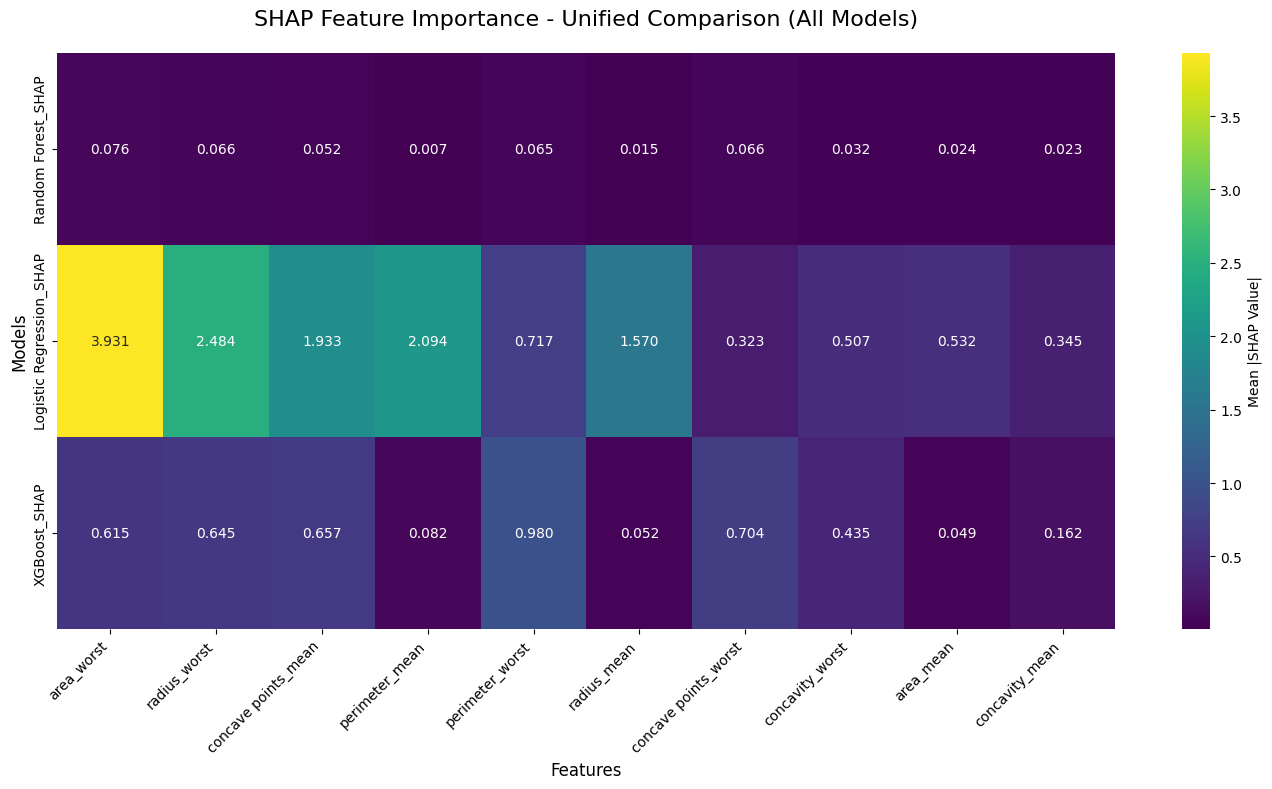

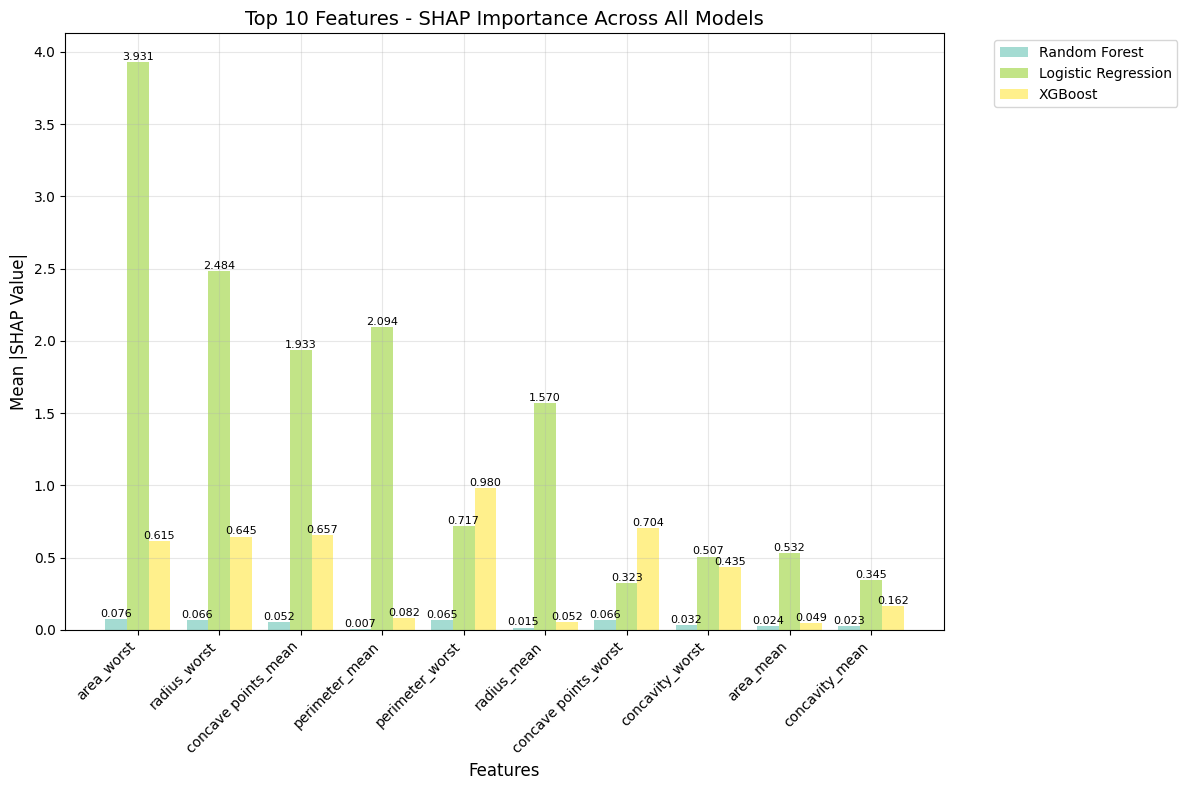


Analyzing feature consensus across models...


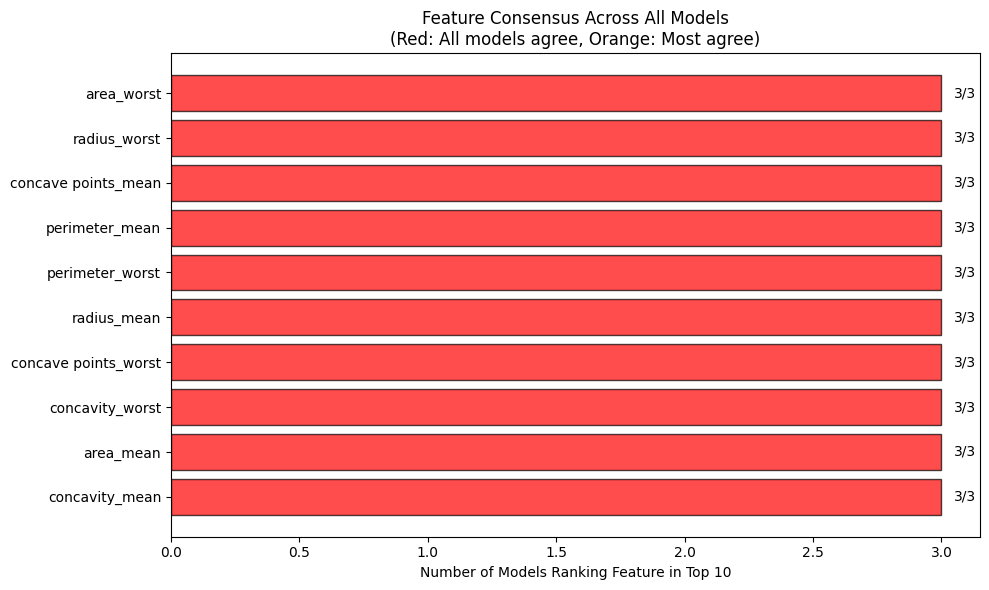


UNIFIED SHAP ANALYSIS SUMMARY
Total models analyzed: 3
Features analyzed: 10

🎯 Features ALL models rank in top 10:
   1. area_worst (consensus: 3/3)
   2. radius_worst (consensus: 3/3)
   3. concave points_mean (consensus: 3/3)
   4. perimeter_mean (consensus: 3/3)
   5. perimeter_worst (consensus: 3/3)

📊 Top 5 features by mean SHAP importance:
   1. area_worst                1.5406
   2. radius_worst              1.0650
   3. concave points_mean       0.8804
   4. perimeter_mean            0.7275
   5. perimeter_worst           0.5875

🔍 Model-specific top features:
   Random Forest        → area_worst (0.0756)
   Logistic Regression  → area_worst (3.9312)
   XGBoost              → perimeter_worst (0.9803)

✅ Unified analysis complete!
📁 All files saved to: results/unified_analysis/
🎉 Unified SHAP comparison completed successfully!


In [ ]:
"""Unified SHAP Comparison - All Models Including Random Forest"""

def create_unified_shap_comparison(best_models, save_dir="results"):
    """
    Create a unified comparison that includes Random Forest and all other models
    """
    print(f"\n{'='*70}")
    print("CREATING UNIFIED SHAP COMPARISON (ALL MODELS)")
    print(f"{'='*70}")

    unified_comparison = {}

    # 1. Load Random Forest SHAP results
    rf_shap_dir = f"{save_dir}/model_outputs/shap_analysis"
    rf_files = []

    for name in best_models.keys():
        if "Forest" in name:
            rf_importance_file = f"{rf_shap_dir}/{name}_shap_global_importance.csv"
            if os.path.exists(rf_importance_file):
                print(f"Loading Random Forest SHAP data: {name}")
                rf_df = pd.read_csv(rf_importance_file)
                top_10 = rf_df.head(10).set_index('feature')['mean_shap_importance']
                unified_comparison[f"{name}_SHAP"] = top_10
                rf_files.append(rf_importance_file)
            break

    # 2. Load other models' SHAP results
    other_models_dir = f"{save_dir}/tables"
    other_files = []

    for name in best_models.keys():
        if "Forest" not in name:  # Skip Random Forest
            importance_file = f"{other_models_dir}/{name}_shap_global_importance.csv"
            if os.path.exists(importance_file):
                print(f"Loading SHAP data: {name}")
                df = pd.read_csv(importance_file)
                top_10 = df.head(10).set_index('feature')['mean_shap_importance']
                unified_comparison[f"{name}_SHAP"] = top_10
                other_files.append(importance_file)

    if not unified_comparison:
        print("❌ No SHAP results found for unified comparison")
        return None

    # 3. Create unified comparison DataFrame
    print(f"Creating unified comparison with {len(unified_comparison)} models...")

    unified_df = pd.DataFrame(unified_comparison).fillna(0)

    # Sort by the first model's importance (or by mean across all models)
    if len(unified_df.columns) > 1:
        unified_df['mean_importance'] = unified_df.mean(axis=1)
        unified_df = unified_df.sort_values('mean_importance', ascending=False)
        unified_df = unified_df.drop('mean_importance', axis=1)
    else:
        unified_df = unified_df.sort_values(unified_df.columns[0], ascending=False)

    # 4. Save unified comparison
    unified_dir = f"{save_dir}/unified_analysis"
    os.makedirs(unified_dir, exist_ok=True)

    unified_df.to_csv(f"{unified_dir}/unified_shap_importance_comparison.csv")
    print(f"✅ Unified comparison saved to: {unified_dir}/unified_shap_importance_comparison.csv")

    # 5. Create comprehensive heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(unified_df.T, annot=True, cmap='viridis', fmt='.3f',
                cbar_kws={'label': 'Mean |SHAP Value|'})
    plt.title("SHAP Feature Importance - Unified Comparison (All Models)", fontsize=16, pad=20)
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Models", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{unified_dir}/unified_shap_heatmap_all_models.png",
               dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 6. Create side-by-side bar chart for top features
    top_10_unified = unified_df.head(10)

    fig, ax = plt.subplots(figsize=(12, 8))
    x_pos = np.arange(len(top_10_unified))
    width = 0.8 / len(top_10_unified.columns)

    colors = plt.cm.Set3(np.linspace(0, 1, len(top_10_unified.columns)))

    for i, (model, color) in enumerate(zip(top_10_unified.columns, colors)):
        offset = (i - len(top_10_unified.columns)/2 + 0.5) * width
        bars = ax.bar(x_pos + offset, top_10_unified[model], width,
                     label=model.replace('_SHAP', ''), color=color, alpha=0.8)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            if height > 0.001:  # Only label significant values
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Mean |SHAP Value|', fontsize=12)
    ax.set_title('Top 10 Features - SHAP Importance Across All Models', fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(top_10_unified.index, rotation=45, ha='right')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{unified_dir}/unified_shap_top10_comparison.png",
               dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 7. Create model consensus analysis
    print("\nAnalyzing feature consensus across models...")

    # Count how many models consider each feature in top 10
    consensus_score = (unified_df > 0).sum(axis=1)
    consensus_df = pd.DataFrame({
        'feature': unified_df.index,
        'consensus_score': consensus_score,
        'mean_importance': unified_df.mean(axis=1),
        'std_importance': unified_df.std(axis=1)
    }).sort_values('consensus_score', ascending=False)

    # Save consensus analysis
    consensus_df.to_csv(f"{unified_dir}/feature_consensus_analysis.csv", index=False)

    # Visualize consensus
    plt.figure(figsize=(10, 6))
    colors = ['red' if score == len(unified_df.columns) else 'orange' if score >= len(unified_df.columns)*0.7 else 'lightblue'
              for score in consensus_df.head(15)['consensus_score']]

    bars = plt.barh(range(len(consensus_df.head(15))), consensus_df.head(15)['consensus_score'],
                    color=colors, alpha=0.7, edgecolor='black')

    plt.yticks(range(len(consensus_df.head(15))), consensus_df.head(15)['feature'])
    plt.xlabel('Number of Models Ranking Feature in Top 10')
    plt.title('Feature Consensus Across All Models\n(Red: All models agree, Orange: Most agree)')
    plt.gca().invert_yaxis()

    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.05, bar.get_y() + bar.get_height()/2,
                f'{int(width)}/{len(unified_df.columns)}', ha='left', va='center')

    plt.tight_layout()
    plt.savefig(f"{unified_dir}/feature_consensus_chart.png",
               dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 8. Summary report
    print(f"\n{'='*50}")
    print("UNIFIED SHAP ANALYSIS SUMMARY")
    print(f"{'='*50}")
    print(f"Total models analyzed: {len(unified_df.columns)}")
    print(f"Features analyzed: {len(unified_df)}")

    # Features all models agree on
    all_agree = consensus_df[consensus_df['consensus_score'] == len(unified_df.columns)]
    if len(all_agree) > 0:
        print(f"\n🎯 Features ALL models rank in top 10:")
        for i, (_, row) in enumerate(all_agree.head(5).iterrows(), 1):
            print(f"   {i}. {row['feature']} (consensus: {int(row['consensus_score'])}/{len(unified_df.columns)})")

    # Top features by mean importance
    print(f"\n📊 Top 5 features by mean SHAP importance:")
    top_mean = unified_df.mean(axis=1).sort_values(ascending=False)
    for i, (feature, importance) in enumerate(top_mean.head(5).items(), 1):
        print(f"   {i}. {feature:<25} {importance:.4f}")

    # Model-specific insights
    print(f"\n🔍 Model-specific top features:")
    for model in unified_df.columns:
        top_feature = unified_df[model].idxmax()
        top_value = unified_df[model].max()
        print(f"   {model.replace('_SHAP', ''):<20} → {top_feature} ({top_value:.4f})")

    print(f"\n✅ Unified analysis complete!")
    print(f"📁 All files saved to: {unified_dir}/")
    print(f"{'='*50}")

    return {
        'unified_df': unified_df,
        'consensus_df': consensus_df,
        'files_created': [
            'unified_shap_importance_comparison.csv',
            'unified_shap_heatmap_all_models.png',
            'unified_shap_top10_comparison.png',
            'feature_consensus_analysis.csv',
            'feature_consensus_chart.png'
        ]
    }

# Run unified comparison
print("Creating unified SHAP comparison including Random Forest...")
unified_results = create_unified_shap_comparison(best_models)

if unified_results:
    print("🎉 Unified SHAP comparison completed successfully!")
else:
    print("❌ Unified comparison failed - check that both SHAP analyses completed successfully")

Generating Word and pdf

In [ ]:
def generate_comprehensive_report(save_filename="Comprehensive_ML_Analysis_Report.docx"):
    """
    Generate a comprehensive Word report using all available results including SHAP analysis
    """
    doc = Document()
    doc.add_heading("Machine Learning Analysis Report: Tumor Tissue Classification", 0)

    # Introduction
    doc.add_paragraph(
        "This comprehensive report presents a machine learning analysis for tumor tissue classification. "
        "The study compares Logistic Regression, Random Forest, and XGBoost models using rigorous "
        "hyperparameter tuning, threshold optimization, feature importance analysis, and SHAP explainability. "
        "All models were evaluated for clinical applicability with emphasis on recall (sensitivity) "
        "for medical screening applications."
    )

    # ===============================
    # DEFINITIONS AND FORMULAS
    # ===============================
    doc.add_heading("Key Definitions and Mathematical Formulas", level=1)

    doc.add_paragraph(
        "This section provides essential definitions and mathematical formulas for statistical "
        "concepts and techniques used throughout this analysis."
    )

    # Statistical Measures
    doc.add_heading("Performance Metrics", level=2)

    doc.add_paragraph(
        "Classification performance is evaluated using the following metrics, derived from the confusion matrix:"
    )

    doc.add_paragraph(
        "Confusion Matrix Components:\n"
        "• True Positives (TP): Correctly identified malignant cases\n"
        "• True Negatives (TN): Correctly identified benign cases\n"
        "• False Positives (FP): Incorrectly identified as malignant (Type I error)\n"
        "• False Negatives (FN): Incorrectly identified as benign (Type II error)"
    )

    doc.add_paragraph(
        "Accuracy: Overall correctness of the model\n"
        "Formula: Accuracy = (TP + TN) / (TP + TN + FP + FN)\n"
        "Range: 0 to 1 (higher is better)\n"
        "Clinical interpretation: Proportion of all cases correctly classified"
    )

    doc.add_paragraph(
        "Precision (Positive Predictive Value): Reliability of positive predictions\n"
        "Formula: Precision = TP / (TP + FP)\n"
        "Range: 0 to 1 (higher is better)\n"
        "Clinical interpretation: Of all cases predicted as malignant, what proportion actually are malignant?"
    )

    doc.add_paragraph(
        "Recall (Sensitivity): Ability to detect positive cases\n"
        "Formula: Recall = TP / (TP + FN)\n"
        "Range: 0 to 1 (higher is better)\n"
        "Clinical interpretation: Of all actual malignant cases, what proportion are correctly identified? "
        "Critical for medical screening to minimize missed diagnoses."
    )

    doc.add_paragraph(
        "Specificity: Ability to correctly identify negative cases\n"
        "Formula: Specificity = TN / (TN + FP)\n"
        "Range: 0 to 1 (higher is better)\n"
        "Clinical interpretation: Of all actual benign cases, what proportion are correctly identified?"
    )

    doc.add_paragraph(
        "F1-Score: Harmonic mean of precision and recall\n"
        "Formula: F1 = 2 × (Precision × Recall) / (Precision + Recall)\n"
        "Range: 0 to 1 (higher is better)\n"
        "Clinical interpretation: Balanced measure when both precision and recall are equally important"
    )

    doc.add_paragraph(
        "F2-Score: Weighted harmonic mean favoring recall\n"
        "Formula: F2 = 5 × (Precision × Recall) / (4 × Precision + Recall)\n"
        "Range: 0 to 1 (higher is better)\n"
        "Clinical interpretation: Emphasizes recall over precision, preferred for medical screening "
        "where missing a positive case is more costly than a false alarm"
    )

    doc.add_paragraph(
        "Youden's J Index: Optimal balance between sensitivity and specificity\n"
        "Formula: J = Sensitivity + Specificity - 1\n"
        "Range: -1 to 1 (higher is better, 0 = random performance)\n"
        "Clinical interpretation: Maximizes the difference between true positive rate and false positive rate. "
        "Used to determine optimal classification thresholds."
    )

    doc.add_paragraph(
        "ROC-AUC (Receiver Operating Characteristic - Area Under Curve):\n"
        "Definition: Area under the curve plotting True Positive Rate vs False Positive Rate at various thresholds\n"
        "Range: 0 to 1 (0.5 = random, 1.0 = perfect)\n"
        "Clinical interpretation: Model's ability to distinguish between classes across all thresholds. "
        "AUC > 0.8 generally considered good, > 0.9 excellent for clinical applications."
    )

    # Dimensionality Reduction Techniques
    doc.add_heading("Dimensionality Reduction Techniques", level=2)

    doc.add_paragraph(
        "Principal Component Analysis (PCA):\n"
        "Definition: Linear dimensionality reduction technique that projects data onto principal components "
        "that capture maximum variance.\n"
        "Mathematical basis: Eigenvalue decomposition of covariance matrix\n"
        "Purpose: Identify the most informative linear combinations of features\n"
        "Clinical interpretation: Reveals which feature combinations explain most variation in the data, "
        "helping identify key biomarker patterns."
    )

    doc.add_paragraph(
        "t-Distributed Stochastic Neighbor Embedding (t-SNE):\n"
        "Definition: Non-linear dimensionality reduction technique that preserves local structure\n"
        "Purpose: Visualize high-dimensional data in 2D/3D while maintaining similarity relationships\n"
        "Mathematical basis: Minimizes divergence between probability distributions in high and low dimensions\n"
        "Clinical interpretation: Reveals natural clustering patterns and separability between classes "
        "that may not be apparent in linear projections."
    )

    # Machine Learning Algorithms
    doc.add_heading("Machine Learning Algorithms", level=2)

    doc.add_paragraph(
        "Logistic Regression:\n"
        "Definition: Linear classifier using logistic function to model probability of binary outcomes\n"
        "Formula: P(y=1|x) = 1 / (1 + e^(-(β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ)))\n"
        "Advantages: Interpretable coefficients, fast training, probabilistic outputs\n"
        "Clinical application: Provides interpretable feature weights indicating biomarker importance"
    )

    doc.add_paragraph(
        "Random Forest:\n"
        "Definition: Ensemble of decision trees using bootstrap aggregating (bagging)\n"
        "Method: Trains multiple decision trees on random subsets of data and features\n"
        "Prediction: Averages predictions across all trees (regression) or majority vote (classification)\n"
        "Advantages: Handles non-linear relationships, feature interactions, robust to overfitting\n"
        "Clinical application: Captures complex biomarker interactions without assuming linear relationships"
    )

    doc.add_paragraph(
        "XGBoost (Extreme Gradient Boosting):\n"
        "Definition: Gradient boosting framework that sequentially builds weak learners\n"
        "Method: Each new tree corrects errors made by previous trees\n"
        "Optimization: Minimizes regularized objective function using gradient descent\n"
        "Advantages: High performance, handles missing values, built-in regularization\n"
        "Clinical application: Often achieves highest accuracy by learning complex patterns "
        "through iterative error correction"
    )

    # SHAP Explanation
    doc.add_heading("Explainability Methods", level=2)

    doc.add_paragraph(
        "SHAP (SHapley Additive exPlanations):\n"
        "Definition: Game-theoretic approach to explain individual predictions\n"
        "Mathematical basis: Shapley values from cooperative game theory\n"
        "Formula: φᵢ = Σ |S|!(|N|-|S|-1)! / |N|! × [f(S ∪ {i}) - f(S)]\n"
        "where φᵢ is feature i's SHAP value, S is subset of features, N is all features\n"
        "Properties: Additivity, symmetry, dummy feature, efficiency\n"
        "Clinical interpretation: Shows exactly how each biomarker contributes to individual patient predictions, "
        "enabling transparent and trustworthy AI-assisted diagnosis."
    )

    doc.add_paragraph("")  # Add space before next section

    # ===============================
    # 1. DATA OVERVIEW
    # ===============================
    doc.add_heading("1. Data Overview and Exploratory Analysis", level=1)

    # Class Distribution
    doc.add_heading("1.1 Class Distribution", level=2)
    if os.path.exists("results/plots/class_distribution.png"):
        doc.add_paragraph("Distribution of target classes in the dataset:")
        doc.add_picture("results/plots/class_distribution.png", width=Inches(5))

    # Sample data preview
    if os.path.exists("results/tables/data_head_SampleData.csv"):
        doc.add_paragraph("Sample data preview (first 5 rows):")
        add_csv_table(doc, "results/tables/data_head_SampleData.csv")

    # Add class distribution table if available
    if os.path.exists("results/tables/class_distribution.csv"):
        doc.add_paragraph("Class distribution statistics:")
        add_csv_table(doc, "results/tables/class_distribution.csv")

    # PCA Analysis
    doc.add_heading("1.2 Principal Component Analysis", level=2)
    if os.path.exists("results/plots/pca_top_10_features.png"):
        doc.add_paragraph("PCA visualization of the top 10 predictive features:")
        doc.add_picture("results/plots/pca_top_10_features.png", width=Inches(5))

    # t-SNE Analysis
    doc.add_heading("1.3 t-SNE Projection", level=2)
    if os.path.exists("results/plots/tsne_projection.png"):
        doc.add_paragraph("t-SNE dimensional reduction visualization:")
        doc.add_picture("results/plots/tsne_projection.png", width=Inches(5))

    # Feature Distributions
    doc.add_heading("1.4 Feature Distributions", level=2)
    if os.path.exists("results/plots/top_10_features_histograms.png"):
        doc.add_paragraph("Distribution of the top 10 most predictive features:")
        doc.add_picture("results/plots/top_10_features_histograms.png", width=Inches(6))

    # ===============================
    # 2. MODEL DEVELOPMENT
    # ===============================
    doc.add_heading("2. Model Development and Hyperparameter Tuning", level=1)

    # Hyperparameter tuning summary
    doc.add_paragraph(
        "Three machine learning algorithms were evaluated: Logistic Regression, Random Forest, "
        "and XGBoost. Each model underwent extensive hyperparameter tuning using 5-fold "
        "cross-validation with ROC-AUC as the optimization metric."
    )

    if os.path.exists("results/tables/hyperparameter_tuning_summary.csv"):
        doc.add_paragraph("Hyperparameter tuning results:")
        add_csv_table(doc, "results/tables/hyperparameter_tuning_summary.csv")

    if os.path.exists("results/tables/hyperparameter_tuning_detailed.csv"):
        doc.add_paragraph("Detailed hyperparameter tuning metrics:")
        add_csv_table(doc, "results/tables/hyperparameter_tuning_detailed.csv")

    # ===============================
    # 3. MODEL PERFORMANCE
    # ===============================
    doc.add_heading("3. Model Performance Evaluation", level=1)

    # Performance Summary
    doc.add_heading("3.1 Overall Performance Metrics", level=2)
    if os.path.exists("results/tables/model_performance_summary.csv"):
        doc.add_paragraph("Key performance metrics for all models:")
        add_csv_table(doc, "results/tables/model_performance_summary.csv")

    if os.path.exists("results/tables/comprehensive_model_results.csv"):
        doc.add_paragraph("Comprehensive model results including threshold analysis:")
        add_csv_table(doc, "results/tables/comprehensive_model_results.csv")

    # Model Rankings
    if os.path.exists("results/tables/model_rankings_by_metric.csv"):
        doc.add_paragraph("Model rankings by different performance metrics:")
        add_csv_table(doc, "results/tables/model_rankings_by_metric.csv")

    # ROC and PR Curves
    doc.add_heading("3.2 ROC and Precision-Recall Curves", level=2)

    # Individual model curves - Fixed file paths
    curve_files = {
        "Logistic Regression": "results/model_outputs/Logistic Regression_roc_pr_curves.png",
        "Random Forest": "results/model_outputs/Random Forest_roc_pr_curves.png",
        "XGBoost": "results/model_outputs_cv/XGBoost_cv_roc_pr_curves.png"
    }

    for model_name, file_path in curve_files.items():
        if os.path.exists(file_path):
            doc.add_paragraph(f"{model_name} ROC and Precision-Recall curves:")
            doc.add_picture(file_path, width=Inches(6))

    # ===============================
    # 4. THRESHOLD OPTIMIZATION
    # ===============================
    doc.add_heading("4. Threshold Optimization Analysis", level=1)

    doc.add_paragraph(
        "Optimal classification thresholds were determined using three metrics:\n\n"
        "• F1-score: Harmonic mean of precision and recall\n"
        "• F2-score: Weighted harmonic mean favoring recall\n"
        "• Youden's J: Sensitivity + Specificity - 1 (optimal balance)"
    )

    # Threshold summary
    if os.path.exists("results/tables/threshold_analysis_summary.csv"):
        doc.add_paragraph("Optimal thresholds for each model:")
        add_csv_table(doc, "results/tables/threshold_analysis_summary.csv")

    # Threshold plots - Updated file paths to check multiple possible locations

    threshold_files = {
        "Logistic Regression": [
            "results/model_outputs/Logistic Regression_threshold_metrics.png",

        ],
        "Random Forest": [
            "results/model_outputs/Random Forest_threshold_metrics.png",
            "results/plots/Random Forest_threshold_analysis.png",
            "results/model_outputs/Random Forest_threshold_analysis.png"
        ],
        "XGBoost": [
            "results/model_outputs_cv/XGBoost_cv_threshold_metrics.png",
            "results/model_outputs_cv/XGBoost_threshold_metrics.png",
            "results/plots/XGBoost_threshold_analysis.png",
            "results/model_outputs_cv/XGBoost_cv_threshold_analysis.png"
        ]
    }

    for model_name, file_paths in threshold_files.items():
        plot_found = False
        for file_path in file_paths:
            if os.path.exists(file_path):
                doc.add_paragraph(f"{model_name} threshold optimization:")
                doc.add_picture(file_path, width=Inches(6))
                doc.add_paragraph(
                    f"This plot shows how different classification thresholds affect {model_name} performance metrics. "
                    f"The optimal thresholds are determined by maximizing F1-score (balanced precision-recall), "
                    f"F2-score (recall-focused), and Youden's J index (sensitivity-specificity balance). "
                    f"For medical screening, F2-score and recall optimization are typically preferred to minimize missed diagnoses."
                )
                plot_found = True
                break

        if not plot_found:
            doc.add_paragraph(f"{model_name} threshold optimization:")
            doc.add_paragraph(f"Threshold optimization plot not found. Expected locations checked:")
            for path in file_paths:
                doc.add_paragraph(f"• {path}")

            # Check if threshold data table exists instead
            threshold_table_paths = [
                f"results/tables/{model_name.lower().replace(' ', '_')}_threshold_analysis.csv",
                f"results/model_outputs/{model_name}_best_thresholds.csv",
                f"results/model_outputs_cv/{model_name}_cv_best_thresholds.csv" if "XGB" in model_name else f"results/model_outputs/{model_name}_best_thresholds.csv"
            ]

            table_found = False
            for table_path in threshold_table_paths:
                if os.path.exists(table_path):
                    doc.add_paragraph(f"Threshold analysis results (from {table_path}):")
                    add_csv_table(doc, table_path)
                    table_found = True
                    break

            if not table_found:
                doc.add_paragraph("No threshold analysis data found for this model.")

            doc.add_paragraph("")

    # ===============================
    # 5. TRADITIONAL FEATURE IMPORTANCE ANALYSIS
    # ===============================
    doc.add_heading("5. Traditional Feature Importance Analysis", level=1)

    # Feature importance comparison
    doc.add_heading("5.1 Feature Importance Comparison", level=2)
    if os.path.exists("results/plots/feature_importances_comparison.png"):
        doc.add_paragraph("Comparison of traditional feature importances across all three models:")
        doc.add_picture("results/plots/feature_importances_comparison.png", width=Inches(7))

    # Top features summary
    if os.path.exists("results/tables/top_5_features_per_model.csv"):
        doc.add_paragraph("Top 5 most important features for each model (traditional methods):")
        add_csv_table(doc, "results/tables/top_5_features_per_model.csv")

    # Individual model feature importance plots - Fixed file paths
    feature_plots = {
        "Logistic Regression": "results/model_outputs/Logistic Regression_logistic_coefficients_plot.png",
        "Random Forest": "results/model_outputs/Random Forest_feature_importances_plot.png",
        "XGBoost": "results/model_outputs_cv/XGBoost_cv_xgb_importances_plot.png"
    }

    doc.add_heading("5.2 Individual Model Feature Importance", level=2)
    for model_name, file_path in feature_plots.items():
        if os.path.exists(file_path):
            doc.add_paragraph(f"{model_name} traditional feature importance analysis:")
            doc.add_picture(file_path, width=Inches(6))

    # ===============================
    # 6. ENHANCED SHAP EXPLAINABILITY ANALYSIS
    # ===============================
    doc.add_heading("6. SHAP Explainability Analysis", level=1)

    doc.add_paragraph(
        "SHAP (SHapley Additive exPlanations) is a game-theoretic approach to explain individual "
        "predictions by computing the contribution of each feature. Unlike traditional feature importance "
        "methods that provide global rankings, SHAP values explain how each feature contributes to "
        "moving the prediction away from the expected (baseline) value for each individual case. "
        "This is particularly valuable in clinical applications where understanding why a model "
        "made a specific prediction for a particular patient is crucial for trust and decision-making."
    )

    # SHAP Global Importance
    doc.add_heading("6.1 SHAP Global Feature Importance", level=2)

    doc.add_paragraph(
        "Global SHAP importance summarizes feature contributions across all predictions by taking "
        "the mean absolute SHAP value for each feature. This provides a model-agnostic way to "
        "rank feature importance that accounts for both positive and negative contributions."
    )

    # SHAP comparison heatmap (from unified analysis)
    if os.path.exists("results/unified_analysis/unified_shap_heatmap_all_models.png"):
        doc.add_paragraph("SHAP feature importance comparison across all models:")
        doc.add_picture("results/unified_analysis/unified_shap_heatmap_all_models.png", width=Inches(7))

        doc.add_paragraph(
            "How to interpret this heatmap:\n"
            "• Darker colors indicate higher SHAP importance values\n"
            "• Each row represents a different model's SHAP analysis\n"
            "• Each column represents a feature from the dataset\n"
            "• Values show the mean absolute SHAP value across all test predictions\n"
            "• Features are ordered by overall importance across models\n"
            "• This allows comparison of which features each model considers most important"
        )
    elif os.path.exists("results/plots/shap_importance_heatmap_comparison.png"):
        doc.add_paragraph("SHAP feature importance comparison across models:")
        doc.add_picture("results/plots/shap_importance_heatmap_comparison.png", width=Inches(7))

    if os.path.exists("results/tables/shap_importance_comparison.csv"):
        doc.add_paragraph("SHAP importance values for top features across models:")
        add_csv_table(doc, "results/tables/shap_importance_comparison.csv")

    # Individual SHAP analyses
    doc.add_heading("6.2 Individual Model SHAP Analysis", level=2)

    # LOGISTIC REGRESSION SHAP
    doc.add_heading("6.2.1 Logistic Regression SHAP Analysis", level=3)

    # Check for standard SHAP files
    lr_shap_importance = "results/plots/Logistic Regression_shap_feature_importance.png"
    if os.path.exists(lr_shap_importance):
        doc.add_paragraph("Logistic Regression SHAP feature importance (global ranking):")
        doc.add_picture(lr_shap_importance, width=Inches(6))

        doc.add_paragraph(
            "Logistic Regression - SHAP Feature Importance Bar Plot Interpretation:\n"
            "• Each bar represents the mean absolute SHAP value for that feature\n"
            "• Longer bars indicate features that have larger average impact on predictions\n"
            "• This shows which features the Logistic Regression model relies on most heavily\n"
            "• Unlike traditional feature importance, SHAP values are additive and sum to the difference between prediction and baseline\n"
            "• Features are ranked from most to least impactful on model decisions"
        )

    lr_shap_summary = "results/plots/Logistic Regression_shap_summary_detailed.png"
    if os.path.exists(lr_shap_summary):
        doc.add_paragraph("Logistic Regression SHAP summary plot showing feature impact distribution:")
        doc.add_picture(lr_shap_summary, width=Inches(6))

        doc.add_paragraph(
            "Logistic Regression - SHAP Summary Plot (Beeswarm) Interpretation:\n"
            "• Each dot represents one patient's SHAP value for that feature\n"
            "• X-axis shows SHAP value (positive = increases malignancy probability, negative = decreases)\n"
            "• Y-axis lists features ordered by importance (top = most important)\n"
            "• Color indicates feature value (red = high feature value, blue = low feature value)\n"
            "• Width of dot cloud shows how much that feature's impact varies across patients\n"
            "• This reveals not just importance, but HOW each feature influences predictions"
        )

    # Waterfall plots for LR
    lr_waterfall_files = [
        "results/plots/Logistic Regression_shap_waterfall_sample_1.png",
        "results/plots/Logistic Regression_shap_waterfall_sample_2.png"
    ]
    lr_waterfall_exists = [f for f in lr_waterfall_files if os.path.exists(f)]
    if lr_waterfall_exists:
        doc.add_paragraph("Logistic Regression SHAP waterfall plots for individual predictions:")
        doc.add_picture(lr_waterfall_exists[0], width=Inches(6))

        doc.add_paragraph(
            "Logistic Regression - SHAP Waterfall Plot Interpretation:\n"
            "• Shows exactly how the model arrived at this specific patient's prediction\n"
            "• Starts from the baseline (expected value across all patients)\n"
            "• Each bar shows how much each feature pushes the prediction up (red) or down (blue)\n"
            "• Features are ordered by magnitude of contribution to this specific prediction\n"
            "• Final prediction is the sum of baseline + all feature contributions\n"
            "• This provides complete transparency for individual clinical decisions"
        )

    # RANDOM FOREST SHAP (using your dedicated RF SHAP analysis files)
    doc.add_heading("6.2.2 Random Forest SHAP Analysis", level=3)

    # Random Forest SHAP files from your dedicated analysis
    rf_shap_dir = "results/model_outputs/shap_analysis"

    # Find the actual Random Forest model name
    rf_importance_files = []
    rf_summary_files = []
    rf_explanation_files = []
    rf_horizontal_files = []

    if os.path.exists(rf_shap_dir):
        for filename in os.listdir(rf_shap_dir):
            if "Forest" in filename:
                if "shap_feature_importance.png" in filename:
                    rf_importance_files.append(os.path.join(rf_shap_dir, filename))
                elif "shap_summary_plot.png" in filename:
                    rf_summary_files.append(os.path.join(rf_shap_dir, filename))
                elif "shap_explanation_" in filename:
                    rf_explanation_files.append(os.path.join(rf_shap_dir, filename))
                elif "shap_importance_horizontal.png" in filename:
                    rf_horizontal_files.append(os.path.join(rf_shap_dir, filename))

    # Display Random Forest SHAP plots
    if rf_importance_files:
        doc.add_paragraph("Random Forest SHAP feature importance (global ranking):")
        doc.add_picture(rf_importance_files[0], width=Inches(6))

        doc.add_paragraph(
            "Random Forest - SHAP Feature Importance Bar Plot Interpretation:\n"
            "• Each bar represents the mean absolute SHAP value for that feature\n"
            "• Tree-based models like Random Forest can capture complex non-linear relationships\n"
            "• SHAP values account for feature interactions automatically captured by the trees\n"
            "• Features are ranked by their average contribution magnitude across all predictions\n"
            "• Unlike Gini importance, SHAP values are consistent and theoretically grounded"
        )

    if rf_summary_files:
        doc.add_paragraph("Random Forest SHAP summary plot showing feature impact distribution:")
        doc.add_picture(rf_summary_files[0], width=Inches(6))

        doc.add_paragraph(
            "Random Forest - SHAP Summary Plot Interpretation:\n"
            "• Shows the relationship between feature values and their impact on predictions\n"
            "• For Random Forest, can reveal non-linear relationships and thresholds\n"
            "• Look for vertical spreads indicating feature interactions\n"
            "• Color patterns show if high/low feature values consistently increase or decrease risk"
        )

    if rf_explanation_files:
        doc.add_paragraph("Random Forest SHAP individual prediction explanations:")
        for rf_file in rf_explanation_files[:2]:  # Show first 2
            doc.add_picture(rf_file, width=Inches(6))

        doc.add_paragraph(
            "Random Forest - Individual Prediction Analysis:\n"
            "• Bar charts show top 10 features by magnitude for specific patients\n"
            "• Blue bars increase malignancy risk, red bars decrease risk\n"
            "• Random Forest can identify complex feature combinations\n"
            "• Each patient's explanation may highlight different feature combinations"
        )

    if rf_horizontal_files:
        doc.add_paragraph("Random Forest SHAP importance (alternative visualization):")
        doc.add_picture(rf_horizontal_files[0], width=Inches(6))

    # XGBOOST SHAP
    doc.add_heading("6.2.3 XGBoost SHAP Analysis", level=3)

    xgb_shap_importance = "results/plots/XGBoost_shap_feature_importance.png"
    if os.path.exists(xgb_shap_importance):
        doc.add_paragraph("XGBoost SHAP feature importance (global ranking):")
        doc.add_picture(xgb_shap_importance, width=Inches(6))

        doc.add_paragraph(
            "XGBoost - SHAP Feature Importance Interpretation:\n"
            "• XGBoost often identifies different important features than other models\n"
            "• Gradient boosting can detect subtle patterns missed by other algorithms\n"
            "• SHAP values account for the sequential nature of boosted trees\n"
            "• Feature importance reflects both individual effects and interaction contributions"
        )

    xgb_shap_summary = "results/plots/XGBoost_shap_summary_detailed.png"
    if os.path.exists(xgb_shap_summary):
        doc.add_picture(xgb_shap_summary, width=Inches(6))

    # XGBoost interactions (if available)
    xgb_interactions = "results/plots/XGBoost_shap_interactions.png"
    if os.path.exists(xgb_interactions):
        doc.add_paragraph("XGBoost SHAP feature interactions heatmap:")
        doc.add_picture(xgb_interactions, width=Inches(6))

        doc.add_paragraph(
            "XGBoost - SHAP Feature Interactions Interpretation:\n"
            "• Shows how pairs of features interact to influence predictions\n"
            "• Off-diagonal cells show interaction strength between feature pairs\n"
            "• Darker colors indicate stronger interactions\n"
            "• High interaction values suggest combined effects different from individual effects\n"
            "• Identifies biomarker combinations that together provide unique diagnostic information"
        )

    # ===============================
    # 6.3 UNIFIED SHAP COMPARISON
    # ===============================
    doc.add_heading("6.3 Unified SHAP Analysis and Clinical Insights", level=2)

    # Top 10 comparison
    if os.path.exists("results/unified_analysis/unified_shap_top10_comparison.png"):
        doc.add_paragraph("Top 10 features comparison across all models using SHAP values:")
        doc.add_picture("results/unified_analysis/unified_shap_top10_comparison.png", width=Inches(7))

        doc.add_paragraph(
            "Top 10 Features Comparison Interpretation:\n"
            "• Each group of bars represents one feature\n"
            "• Different colored bars show different models' SHAP importance for that feature\n"
            "• Height of bars indicates mean absolute SHAP value\n"
            "• Features with consistent agreement across models are likely most reliable for clinical use\n"
            "• Large differences between models may indicate feature instability or model-specific biases"
        )

    # Feature consensus
    if os.path.exists("results/unified_analysis/feature_consensus_chart.png"):
        doc.add_paragraph("Feature consensus analysis across all models:")
        doc.add_picture("results/unified_analysis/feature_consensus_chart.png", width=Inches(6))

        doc.add_paragraph(
            "Feature Consensus Chart Interpretation:\n"
            "• Shows how many models rank each feature in their top 10 most important\n"
            "• Red bars: Features ALL models consider highly important (strongest clinical evidence)\n"
            "• Orange bars: Features MOST models consider important (good clinical candidates)\n"
            "• Light blue bars: Features only some models consider important (require careful evaluation)\n"
            "• This analysis helps prioritize biomarkers for clinical implementation"
        )

    # Clinical recommendations
    doc.add_heading("6.4 Clinical Implementation Recommendations", level=2)

    doc.add_paragraph(
        "Based on the comprehensive SHAP analysis, the following clinical implementation strategy is recommended:\n\n"
        "1. Prioritize biomarkers with high consensus scores across all models for clinical deployment\n\n"
        "2. Use SHAP waterfall plots to explain individual patient predictions to clinical staff, enhancing trust and interpretability\n\n"
        "3. Monitor for cases where SHAP explanations conflict with clinical intuition, which may indicate model limitations or novel biomarker relationships\n\n"
        "4. Consider feature interactions when interpreting complex cases, particularly for tree-based models\n\n"
        "5. Regularly validate that SHAP explanations remain clinically meaningful as models are updated or retrained\n\n"
        "6. Focus on features that show consistent directional effects across models for reliable clinical guidance"
    )

    # ===============================
    # 7. FEATURE SELECTION ANALYSIS
    # ===============================
    doc.add_heading("7. Feature Selection and Consistency", level=1)

    # Common features
    if os.path.exists("results/tables/common_features_all_models.csv"):
        doc.add_paragraph("Features consistently selected by all three models (threshold > 0.05 importance):")
        add_csv_table(doc, "results/tables/common_features_all_models.csv")

    # Model-specific selections
    selection_files = [
        ("Logistic Regression", "results/tables/lr_selected_features.csv"),
        ("Random Forest", "results/tables/rf_selected_features.csv"),
        ("XGBoost", "results/tables/xgb_selected_features.csv")
    ]

    for model_name, file_path in selection_files:
        if os.path.exists(file_path):
            doc.add_paragraph(f"{model_name} selected features:")
            add_csv_table(doc, file_path)

    # ===============================
    # 8. CLINICAL DECISION SUPPORT
    # ===============================
    doc.add_heading("8. Clinical Decision Support", level=1)

    doc.add_paragraph(
        "For medical screening applications, recall (sensitivity) is typically prioritized "
        "to minimize false negatives. The SHAP analysis provides additional clinical insights "
        "by explaining individual predictions, which enhances trust and interpretability in "
        "clinical settings. The following analysis provides clinical recommendations:"
    )

    if os.path.exists("results/tables/clinical_decision_support.csv"):
        doc.add_paragraph("Clinical decision support analysis:")
        add_csv_table(doc, "results/tables/clinical_decision_support.csv")

    if os.path.exists("results/tables/model_results_with_clinical_preference.csv"):
        doc.add_paragraph("Model results with clinical preferences highlighted:")
        add_csv_table(doc, "results/tables/model_results_with_clinical_preference.csv")

    # ===============================
    # 9. DETAILED MODEL RESULTS
    # ===============================
    doc.add_heading("9. Detailed Model Results", level=1)

    # Confusion matrices and classification reports for each model
    model_details = [
        ("Logistic Regression", "results/model_outputs"),
        ("Random Forest", "results/model_outputs"),
        ("XGBoost", "results/model_outputs_cv")
    ]

    for model_name, base_path in model_details:
        doc.add_heading(f"9.{model_details.index((model_name, base_path)) + 1} {model_name} Detailed Results", level=2)

        # Confusion matrix
        cm_file = f"{base_path}/{model_name}_confusion_matrix.csv" if "cv" not in base_path else f"{base_path}/{model_name}_cv_confusion_matrix.csv"
        if os.path.exists(cm_file):
            doc.add_paragraph("Confusion Matrix:")
            add_csv_table(doc, cm_file)

        # Classification report
        cr_file = f"{base_path}/{model_name}_classification_report.csv" if "cv" not in base_path else f"{base_path}/{model_name}_cv_classification_report.csv"
        if os.path.exists(cr_file):
            doc.add_paragraph("Classification Report:")
            add_csv_table(doc, cr_file)

        # Best thresholds
        bt_file = f"{base_path}/{model_name}_best_thresholds.csv" if "cv" not in base_path else f"{base_path}/{model_name}_cv_best_thresholds.csv"
        if os.path.exists(bt_file):
            doc.add_paragraph("Best Thresholds Analysis:")
            add_csv_table(doc, bt_file)

    # ===============================
    # 10. CONCLUSIONS AND RECOMMENDATIONS
    # ===============================
    doc.add_heading("10. Conclusions and Recommendations", level=1)

    doc.add_paragraph(
        "This comprehensive analysis evaluated three machine learning models for tumor tissue "
        "classification using both traditional and advanced explainability methods. Key findings include:\n\n"
        "• All models achieved good performance with proper hyperparameter tuning\n"
        "• Threshold optimization revealed trade-offs between precision and recall\n"
        "• Traditional feature importance identified key predictive biomarkers\n"
        "• SHAP analysis provided deeper insights into individual predictions and feature interactions\n"
        "• Clinical recommendations prioritize models with highest recall for screening applications\n"
        "• SHAP explainability enhances clinical trust and interpretability\n\n"
        "The combination of rigorous model evaluation and advanced explainability provides a robust "
        "foundation for clinical decision-making with appropriate model selection based on specific "
        "use case requirements. The SHAP analysis particularly enhances the clinical applicability "
        "by providing interpretable explanations for individual patient predictions."
    )

    # Save the document
    doc.save(save_filename)
    print(f"Comprehensive report generated: {save_filename}")
    print(f"Total sections: 10 (including enhanced SHAP analysis)")
    print(f"Document includes all available plots and tables from results directories")
    print(f"SHAP visualizations integrated with detailed explanations")

    return save_filename

def add_csv_table(doc, csv_path, max_rows=20, max_cols=6):
    """
    Add a CSV file as a table to the Word document with intelligent formatting for wide tables
    """
    try:
        df = pd.read_csv(csv_path)
        original_shape = df.shape

        # Handle specific problematic tables
        if "data_head_SampleData.csv" in csv_path:
            # For sample data, show only first few columns and transpose if too wide
            if len(df.columns) > max_cols:
                # Show first 5 rows and first 6 columns
                df_subset = df.iloc[:5, :max_cols]
                doc.add_paragraph(f"Sample data preview (showing first 5 rows and first {max_cols} columns out of {original_shape[1]} total columns):")

                # Create table
                table = doc.add_table(rows=1, cols=len(df_subset.columns))
                table.style = 'Light Grid Accent 1'

                # Add headers
                hdr_cells = table.rows[0].cells
                for i, col in enumerate(df_subset.columns):
                    hdr_cells[i].text = str(col)
                    hdr_cells[i].paragraphs[0].runs[0].bold = True

                # Add data rows
                for _, row in df_subset.iterrows():
                    row_cells = table.add_row().cells
                    for i, val in enumerate(row):
                        row_cells[i].text = str(val)[:20] + "..." if len(str(val)) > 20 else str(val)

                doc.add_paragraph("")
                return

        elif "clinical_preference" in csv_path or "comprehensive_model_results" in csv_path:
            # For wide results tables, create a more readable format
            if len(df.columns) > max_cols:
                doc.add_paragraph(f"Table summary (original size: {original_shape[0]} rows × {original_shape[1]} columns):")

                # Create key-value pairs for each row
                for idx, (_, row) in enumerate(df.iterrows()):
                    if idx >= max_rows:
                        break

                    # Create a mini-table for each model/row
                    doc.add_paragraph(f"Row {idx + 1}:", style='Heading 6')

                    # Create 2-column table (Parameter, Value)
                    mini_table = doc.add_table(rows=1, cols=2)
                    mini_table.style = 'Light List Accent 1'

                    # Headers
                    mini_table.rows[0].cells[0].text = "Parameter"
                    mini_table.rows[0].cells[1].text = "Value"
                    for cell in mini_table.rows[0].cells:
                        cell.paragraphs[0].runs[0].bold = True

                    # Add key-value pairs
                    for col, val in row.items():
                        row_cells = mini_table.add_row().cells
                        row_cells[0].text = str(col)
                        # Format values nicely
                        if isinstance(val, float):
                            row_cells[1].text = f"{val:.4f}" if abs(val) < 1 else f"{val:.2f}"
                        else:
                            row_cells[1].text = str(val)

                    doc.add_paragraph("")  # Space between mini-tables

                if len(df) > max_rows:
                    doc.add_paragraph(f"(Showing first {max_rows} entries out of {len(df)} total)")

                return

        # Standard table handling for normal-width tables
        if len(df) > max_rows:
            df = df.head(max_rows)
            doc.add_paragraph(f"(Showing first {max_rows} rows of {original_shape[0]} total)")

        if len(df.columns) > max_cols:
            # If still too many columns, show first max_cols
            df = df.iloc[:, :max_cols]
            doc.add_paragraph(f"(Showing first {max_cols} columns of {original_shape[1]} total)")

        # Create standard table
        table = doc.add_table(rows=1, cols=len(df.columns))
        table.style = 'Light Grid Accent 1'

        # Add headers with bold formatting
        hdr_cells = table.rows[0].cells
        for i, col in enumerate(df.columns):
            hdr_cells[i].text = str(col)
            hdr_cells[i].paragraphs[0].runs[0].bold = True

        # Add data rows
        for _, row in df.iterrows():
            row_cells = table.add_row().cells
            for i, val in enumerate(row):
                # Format numeric values nicely
                if isinstance(val, float):
                    row_cells[i].text = f"{val:.4f}" if abs(val) < 1 else f"{val:.2f}"
                else:
                    # Truncate very long text
                    text_val = str(val)
                    row_cells[i].text = text_val[:30] + "..." if len(text_val) > 30 else text_val

        doc.add_paragraph("")  # Add space after table

    except Exception as e:
        doc.add_paragraph(f"Error loading table from {csv_path}: {str(e)}")

def add_simple_list(doc, csv_path, title=None):
    """
    Add CSV data as a simple bulleted list instead of table (for very wide data)
    """
    try:
        df = pd.read_csv(csv_path)

        if title:
            doc.add_paragraph(title)

        for idx, (_, row) in enumerate(df.iterrows()):
            if idx >= 10:  # Limit to first 10 items
                break

            # Create a paragraph for each row
            para = doc.add_paragraph(style='List Bullet')

            # Add key information from the row
            key_info = []
            for col, val in row.items():
                if isinstance(val, float):
                    key_info.append(f"{col}: {val:.3f}")
                else:
                    key_info.append(f"{col}: {val}")

            para.add_run(" | ".join(key_info[:4]))  # Show first 4 columns only

        if len(df) > 10:
            doc.add_paragraph(f"(Showing first 10 entries out of {len(df)} total)")

        doc.add_paragraph("")

    except Exception as e:
        doc.add_paragraph(f"Error creating list from {csv_path}: {str(e)}")

# Usage
def run_report_generation():
    """
    Generate the comprehensive report with enhanced SHAP analysis
    """
    filename = generate_comprehensive_report()
    return filename

In [ ]:
filename = run_report_generation()

Comprehensive report generated: Comprehensive_ML_Analysis_Report.docx
Total sections: 10 (including enhanced SHAP analysis)
Document includes all available plots and tables from results directories
SHAP visualizations integrated with detailed explanations
